# Imports and Data Reading

## Imports

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
import seaborn as sns
import os
import numpy as np
from scipy.stats.mstats import winsorize
import random
import joblib
import pathlib

from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection   import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import ttest_1samp
from sklearn.metrics import make_scorer

plt.style.use('dark_background')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## Data Reading and Summary

In [2]:
def model_display(train):
    '''
    Function: model_display
    ------------------------
    Provides a quick overview of the input DataFrame, including:
    - Shape (rows, columns)
    - Data types of each column
    - Descriptive statistics for numerical features
    - First few rows of the dataset
    
    Parameters:
    - train (pd.DataFrame): The input training dataset

    Returns:
    - None (displays information directly)
    '''
    
    # Display shape of the dataset
    print(f'Dataset shape: {train.shape}')
    print('='*50)

    # Display data types of all columns
    print('Column data types:')
    display(train.dtypes)
    print('='*50)

    # Display summary statistics for numerical columns
    print('Summary statistics (numerical columns):')
    display(train.describe())
    print('='*50)

    # Preview the first few rows of the dataset
    print('First few rows of the dataset:')
    display(train.head())

# Load training data from Parquet file
train = pd.read_parquet('./training_data.parquet')

# Display basic structure and summary of the dataset
model_display(train)


Dataset shape: (12100, 9)
Column data types:


date       datetime64[ns]
firm_id             int64
macro1             object
macro2            float64
price             float64
firm1             float64
firm2             float64
firm3             float64
ret               float64
dtype: object

Summary statistics (numerical columns):


,date,firm_id,macro2,price,firm1,firm2,firm3,ret
count,12100,12100.000000,12100.000000,12100.000000,12100.000000,12100.000000,12100.000000,12100.000000
mean,2020-03-01 00:00:00,49.500000,-0.582961,141.188960,0.024705,0.021550,0.009670,-0.001010
min,2020-01-01 00:00:00,0.000000,-2.986708,7.002039,-1.400862,-2.821420,-1.823757,-0.254047
25%,2020-01-31 00:00:00,24.750000,-1.201005,61.972243,-0.212695,-0.359549,-0.240290,-0.058832
50%,2020-03-01 00:00:00,49.500000,-0.616099,125.683412,0.019438,0.024645,0.006752,-0.006339
75%,2020-03-31 00:00:00,74.250000,0.008259,206.407505,0.253699,0.408466,0.253598,0.054219
max,2020-04-30 00:00:00,99.000000,1.831133,495.830892,2.316590,3.061011,2.623558,0.410168
std,NaN,28.867263,0.900100,93.012463,0.353883,0.576792,0.380795,0.082814


First few rows of the dataset:


,date,firm_id,macro1,macro2,price,firm1,firm2,firm3,ret
0,2020-01-01,0,Recovery,-0.226155,276.226209,0.061042,0.034084,-0.847778,0.005584
1,2020-01-01,1,Recovery,-0.226155,83.808180,-1.202923,-1.810058,0.346567,-0.022935
2,2020-01-01,2,Recovery,-0.226155,149.170163,-0.872318,-0.861621,-0.092319,-0.029843
3,2020-01-01,3,Recovery,-0.226155,48.770836,0.831588,-0.136184,-1.165729,-0.003266
4,2020-01-01,4,Recovery,-0.226155,109.207015,0.827317,-1.984357,-1.408475,0.035171


# Data Typecasting + Downsizing

In [3]:
def downcasting_and_typecasting_columns(train):
    '''
    Function: downcasting_and_typecasting_columns
    --------------------------------------------
    Downcasts numeric columns in a DataFrame to more memory-efficient types,
    and typecasts object columns to categorical where appropriate.

    Parameters:
    - train (pd.DataFrame): Input DataFrame to optimize

    Returns:
    - pd.DataFrame: Optimized DataFrame with reduced memory usage
    '''
    
    for col in tqdm(train.columns, total=len(train.columns), desc='Downcasting/train typecasting'):
        col_dtype = train[col].dtype

        # Handle integer columns: downcast to smallest appropriate subtype (e.g., int8, int16)
        if pd.api.types.is_integer_dtype(col_dtype):
            train[col] = pd.to_numeric(train[col], downcast='integer')
            print(f'Downcasted integer column: {col}')

        # Handle float columns: downcast to float32 or float16
        elif pd.api.types.is_float_dtype(col_dtype):
            train[col] = pd.to_numeric(train[col], downcast='float')
            print(f'Downcasted float column: {col}')

        # Handle datetime columns: ensure consistent datetime64 dtype
        elif pd.api.types.is_datetime64_any_dtype(col_dtype):
            try:
                print(f'Typecasting datetime column: {col}')
                train[col] = pd.to_datetime(train[col])
            except Exception as e:
                print(f'Failed to typecast datetime column: {col}')
                print(f'Error: {e}')

        # Handle object columns: convert to category to reduce memory
        elif pd.api.types.is_object_dtype(col_dtype):
            print(f'Typecasting object column to category: {col}')
            train[col] = train[col].astype('category')

    return train

# Log memory info before downcasting
print('=' * 50)
print('Data types and memory usage BEFORE downcasting and typecasting')
print('=' * 50)
display(train.info())
print('=' * 50)

# Apply downcasting/typecasting
train = downcasting_and_typecasting_columns(train)

# Log memory info after downcasting
print('=' * 50)
print('Data types and memory usage AFTER downcasting and typecasting')
print('=' * 50)
display(train.info())
print('=' * 50)


Data types and memory usage BEFORE downcasting and typecasting
<class 'pandas.core.frame.DataFrame'>
Index: 12100 entries, 0 to 12099
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     12100 non-null  datetime64[ns]
 1   firm_id  12100 non-null  int64         
 2   macro1   12100 non-null  object        
 3   macro2   12100 non-null  float64       
 4   price    12100 non-null  float64       
 5   firm1    12100 non-null  float64       
 6   firm2    12100 non-null  float64       
 7   firm3    12100 non-null  float64       
 8   ret      12100 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 945.3+ KB


None

Downcasting/train typecasting: 100%|██████████| 9/9 [00:00<00:00, 612.54it/s]

Typecasting datetime column: date
Downcasted integer column: firm_id
Typecasting object column to category: macro1
Downcasted float column: macro2
Downcasted float column: price
Downcasted float column: firm1
Downcasted float column: firm2
Downcasted float column: firm3
Downcasted float column: ret
Data types and memory usage AFTER downcasting and typecasting
<class 'pandas.core.frame.DataFrame'>
Index: 12100 entries, 0 to 12099
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     12100 non-null  datetime64[ns]
 1   firm_id  12100 non-null  int8          
 2   macro1   12100 non-null  category      
 3   macro2   12100 non-null  float32       
 4   price    12100 non-null  float32       
 5   firm1    12100 non-null  float32       
 6   firm2    12100 non-null  float32       
 7   firm3    12100 non-null  float32       
 8   ret      12100 non-null  float32       
dtypes: category(1), datetime64[ns](1), 

None

# Data Visualizations - Firm Wise

Firm ID: 21
Plotting feature: macro2


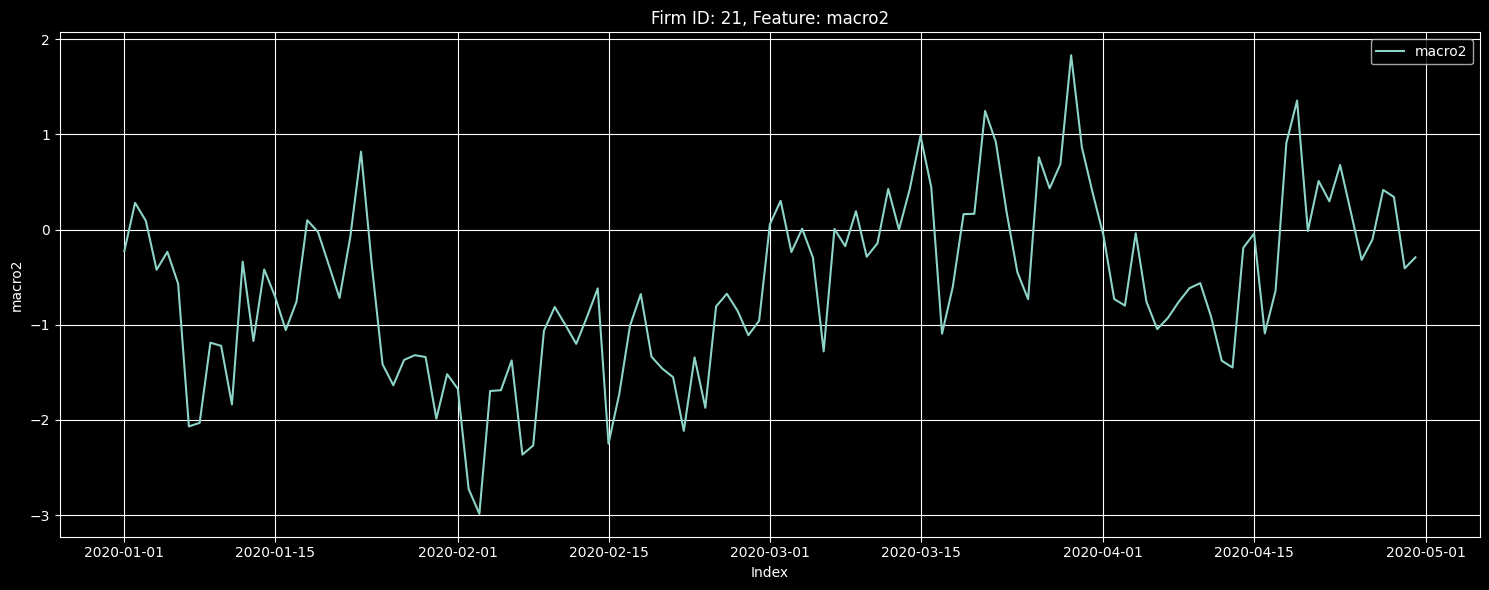

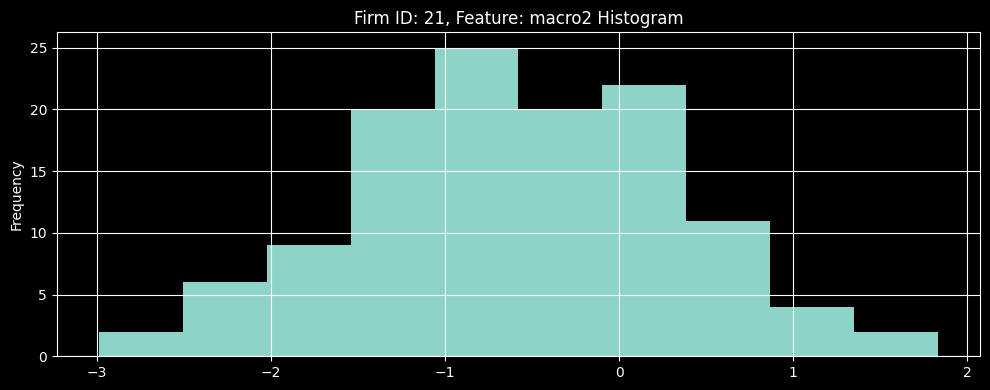

Plotting feature: price


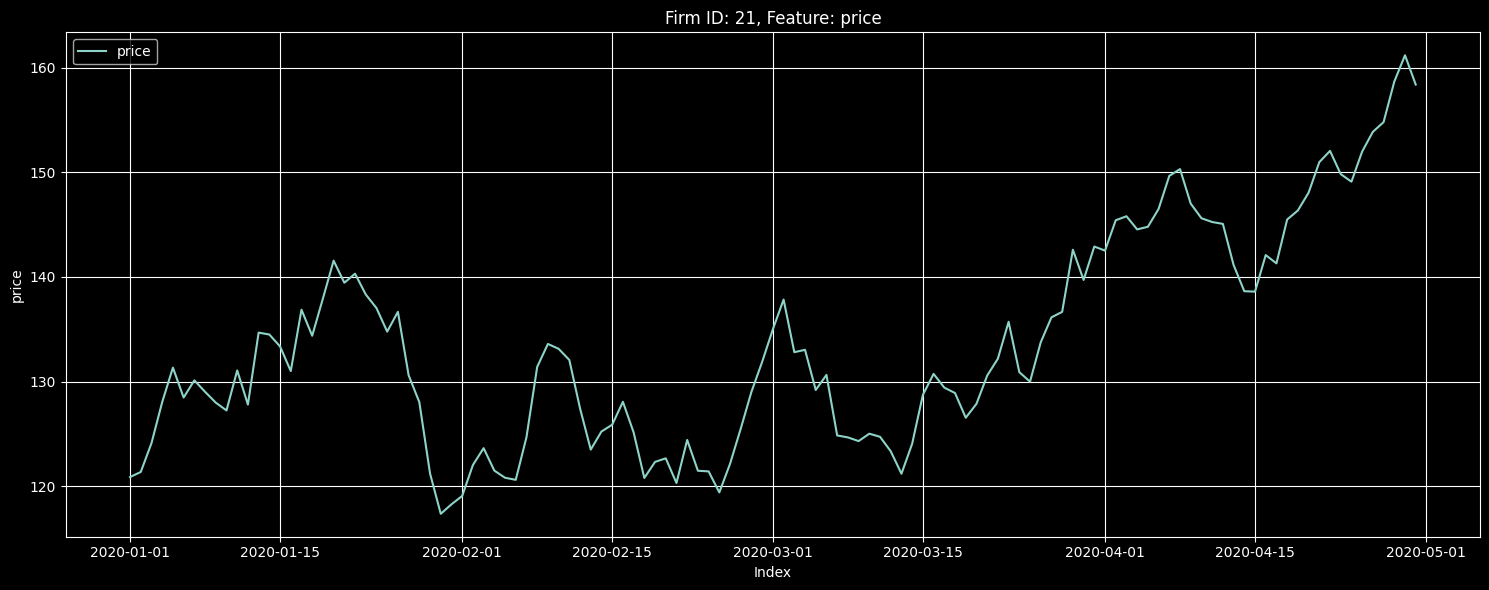

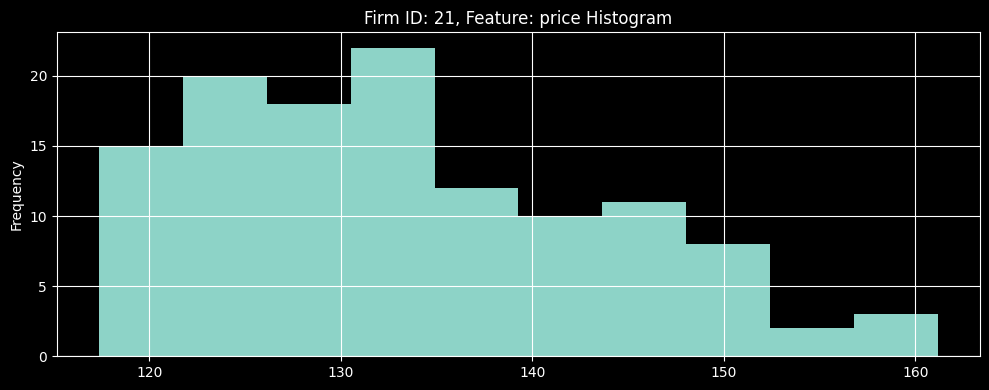

Plotting feature: firm1


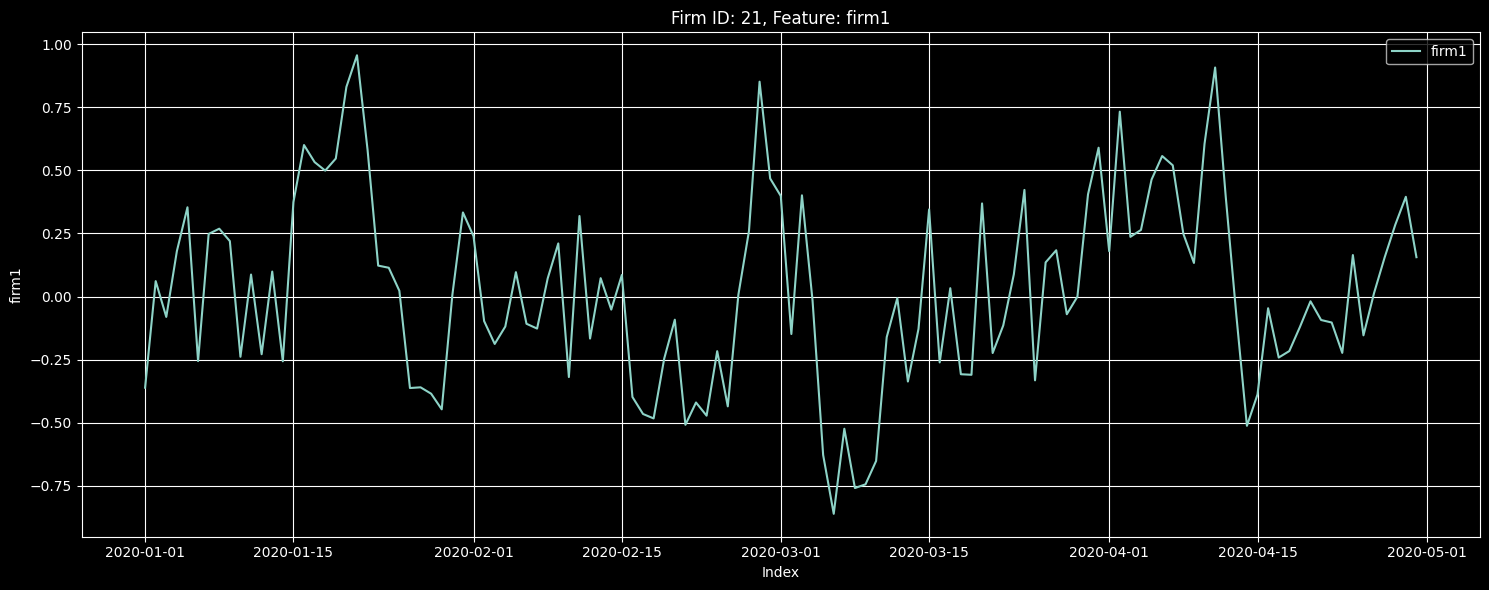

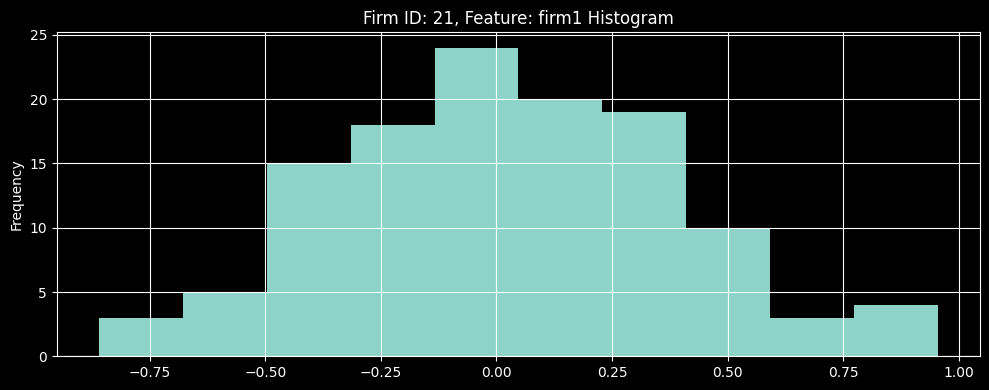

Plotting feature: firm2


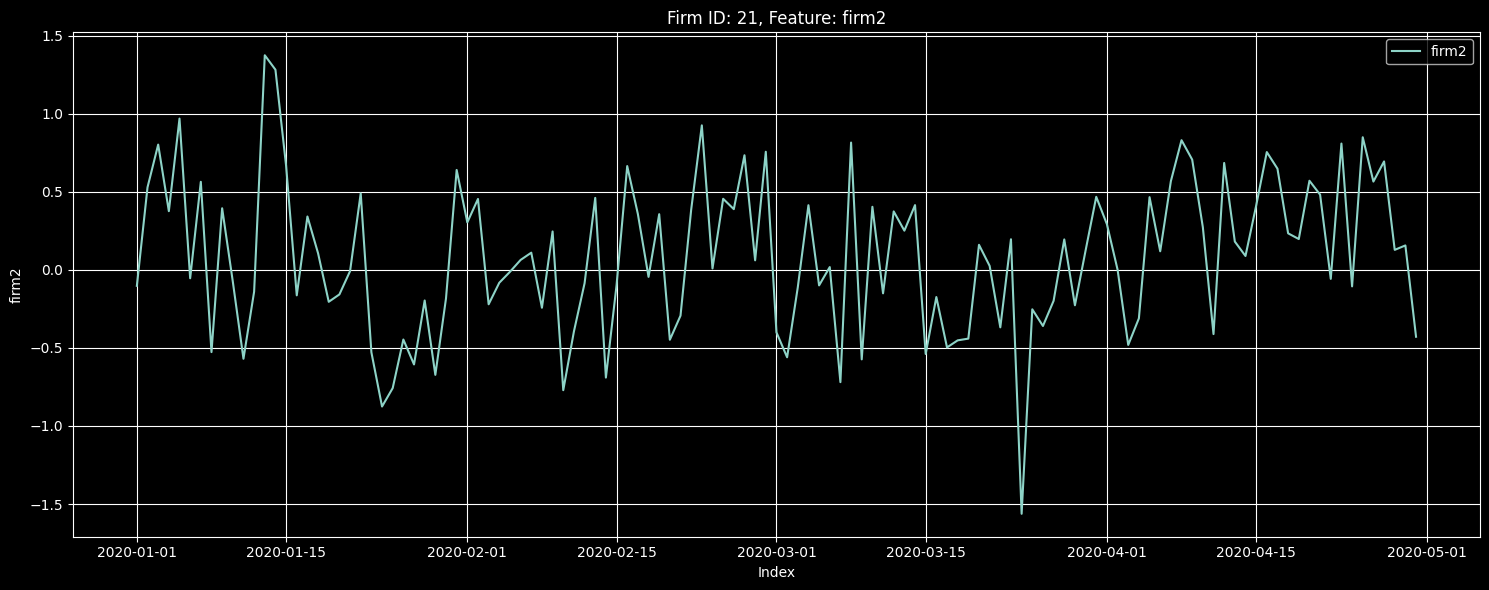

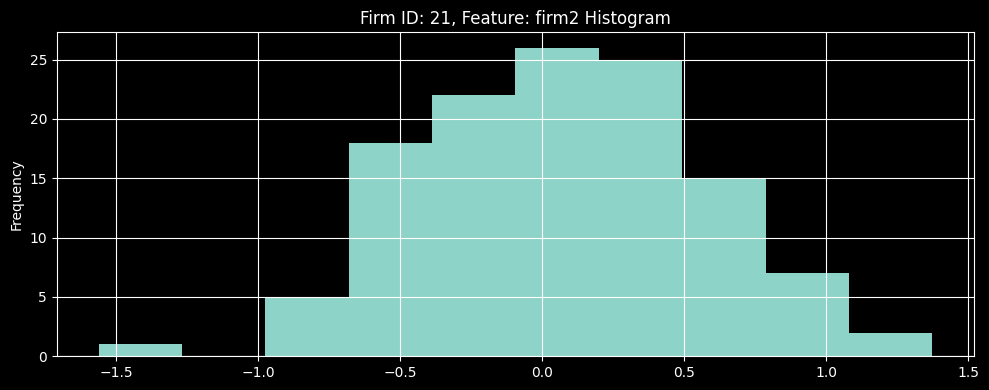

Plotting feature: firm3


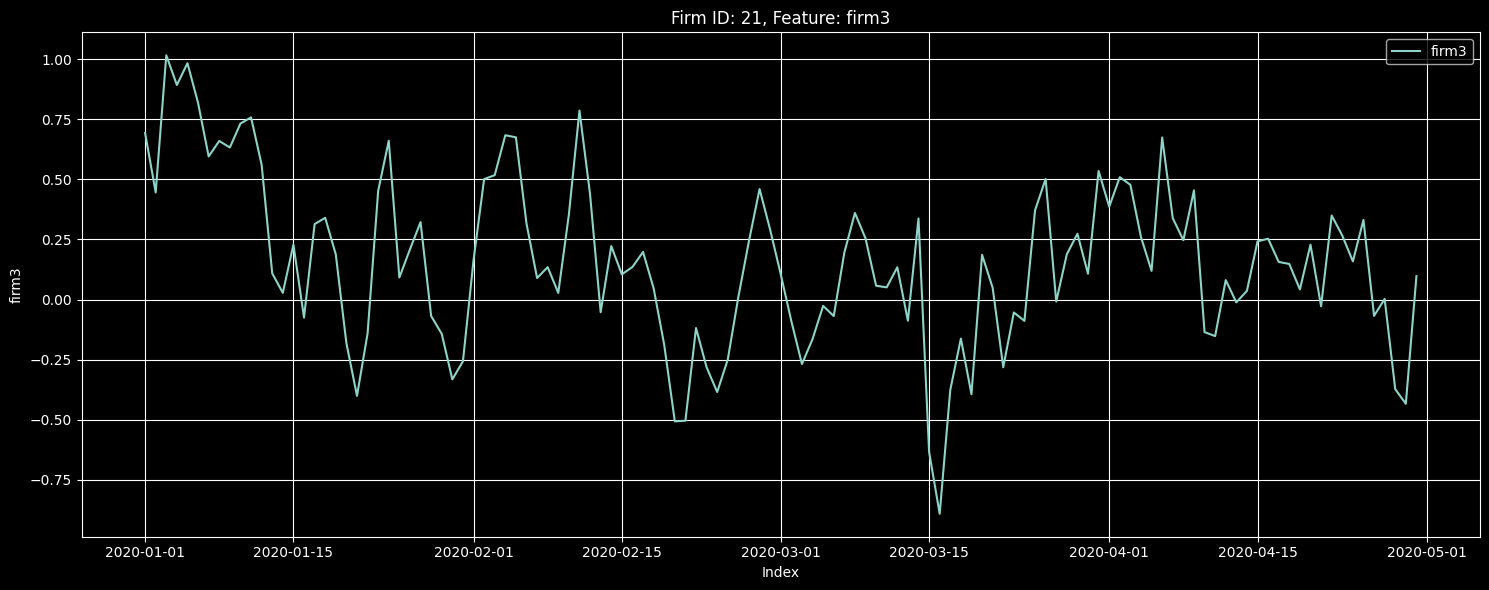

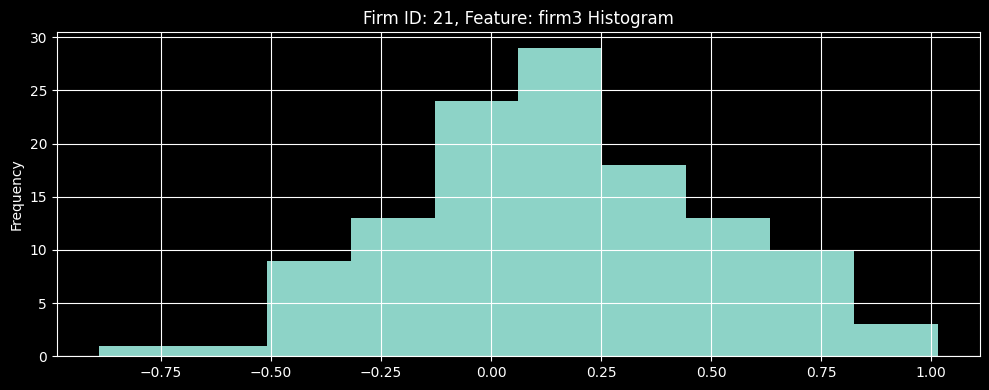

Plotting feature: ret


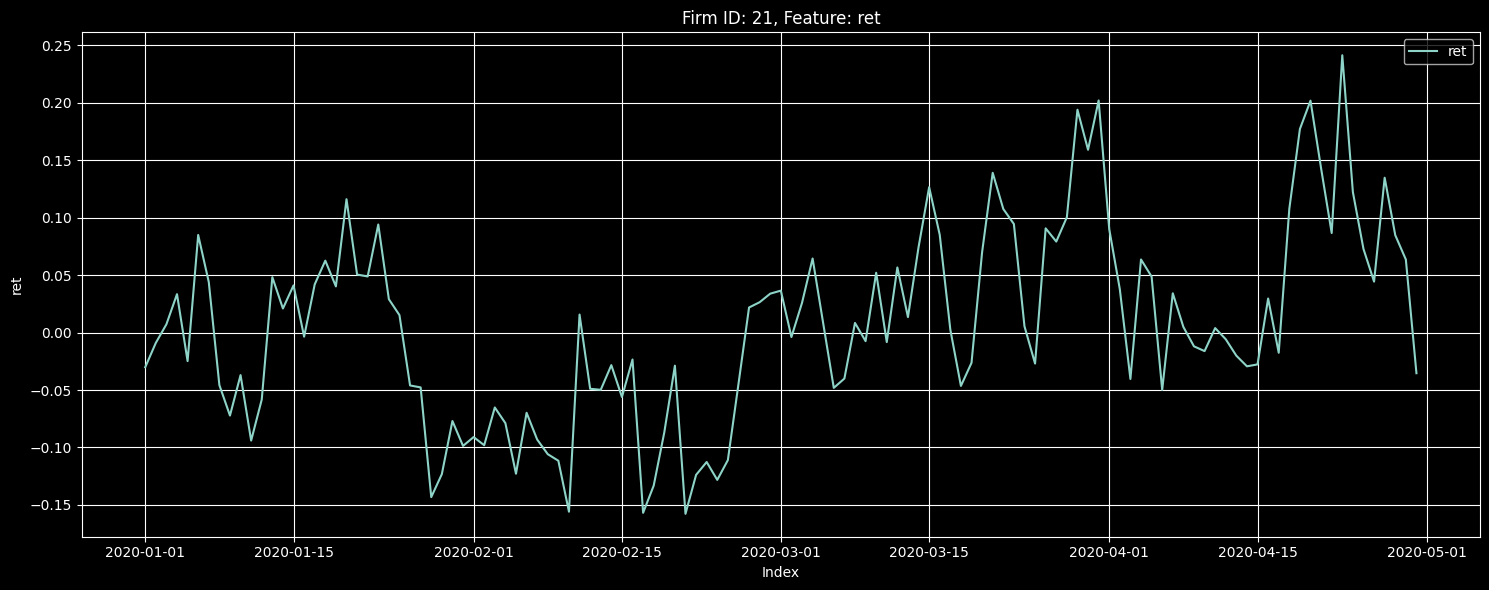

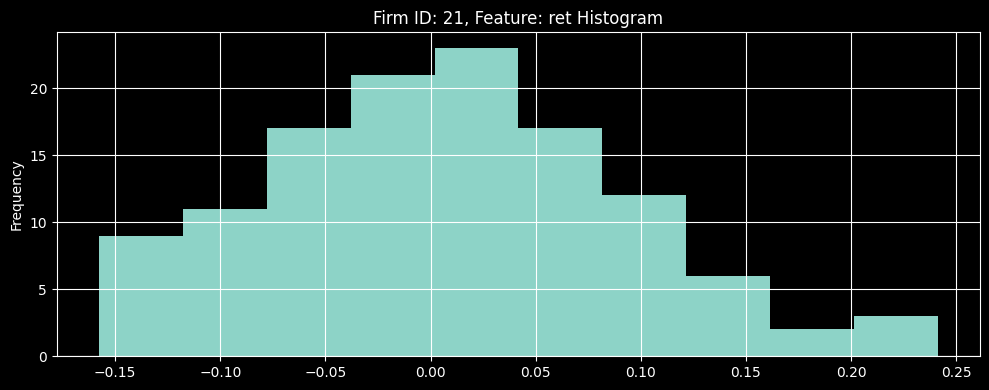

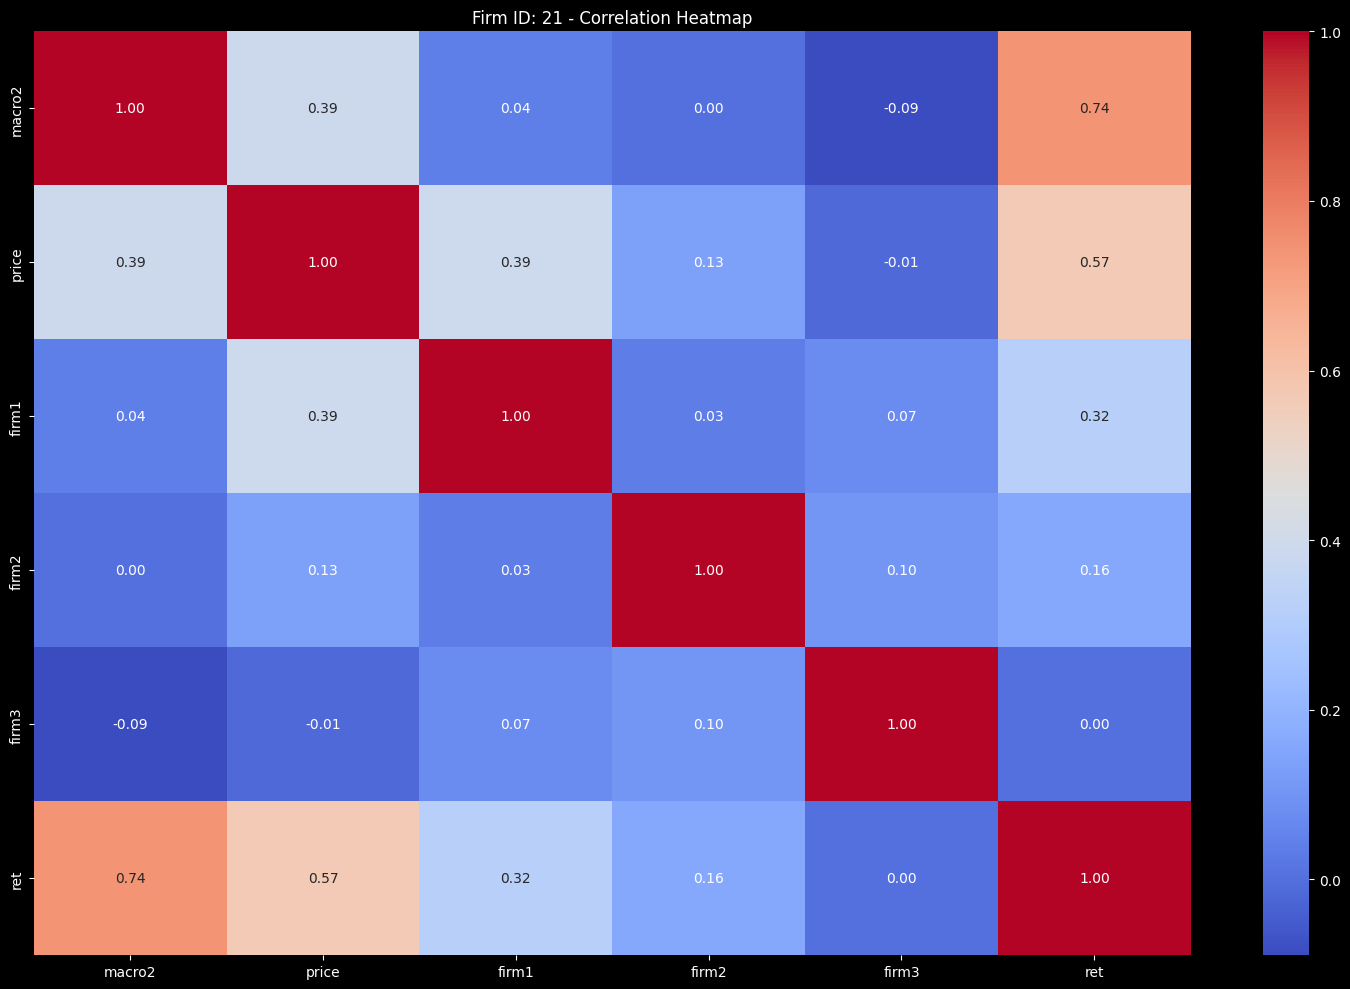

In [4]:

def plot_data(firm_id, df, y_col, x_col=None):
    '''
    Plots a time series or line chart for a given feature (y_col) of a firm.

    Parameters:
    - firm_id: ID of the firm being plotted (used in the title)
    - df: DataFrame filtered for a specific firm
    - y_col: Name of the feature/column to plot on the y-axis
    - x_col: (Optional) Column to use as x-axis; if None, uses DataFrame index

    Returns:
    - None (displays the plot)
    '''
    plt.figure(figsize=(15, 6))

    x = df[x_col] if x_col else df.index
    y = df[y_col]

    plt.plot(x, y, label=y_col)
    
    plt.title(f'Firm ID: {firm_id}, Feature: {y_col}')
    plt.xlabel(x_col if x_col else 'Index')
    plt.ylabel(y_col)

    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_heatmap(firm_df, firm_id):
    '''
    Plots a correlation heatmap for numerical features in the firm-specific DataFrame.

    Parameters:
    - firm_df: DataFrame filtered for a specific firm
    - firm_id: ID of the firm (used in the plot title)

    Returns:
    - None (displays the heatmap)
    '''
    plt.figure(figsize=(15, 10))

    # Exclude non-feature columns
    corr_cols = [col for col in firm_df.columns if col not in ['firm_id', 'macro1']]
    sns.heatmap(firm_df[corr_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")

    plt.title(f'Firm ID: {firm_id} - Correlation Heatmap')
    plt.tight_layout()
    plt.show()


# Prepare dataset for firm-wise plotting (sorted by date, indexed by date)
plot_df = train.sort_values(['date']).reset_index(drop=True).set_index(['date'])

# Get list of all firm_ids in the dataset
firm_ids = train['firm_id'].unique()

# Randomly select one firm
firm_id = random.choice(list(firm_ids))
firm_df = plot_df[plot_df['firm_id'] == firm_id]

print(f'Firm ID: {firm_id}')

# Plot time series and histogram for each numerical feature
for col in [col for col in firm_df.columns if col not in ['firm_id', 'macro1']]:
    print(f'Plotting feature: {col}')
    plot_data(firm_id, firm_df, col)
    firm_df[col].plot(kind='hist', bins=10, title=f'Firm ID: {firm_id}, Feature: {col} Histogram', figsize=(10, 4))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot correlation heatmap for selected firm
plot_heatmap(firm_df, firm_id)


# Full Data Plots - Distribution

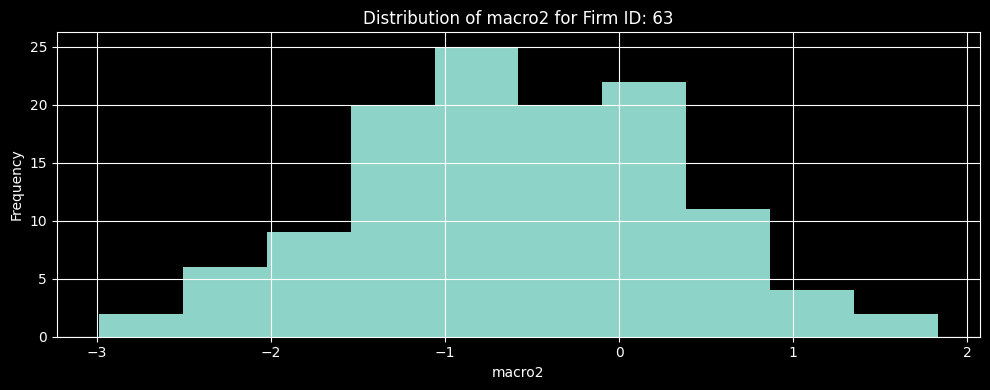

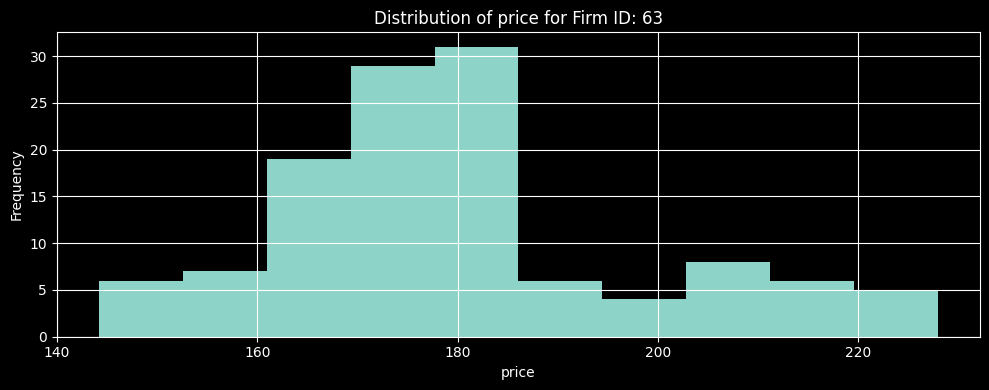

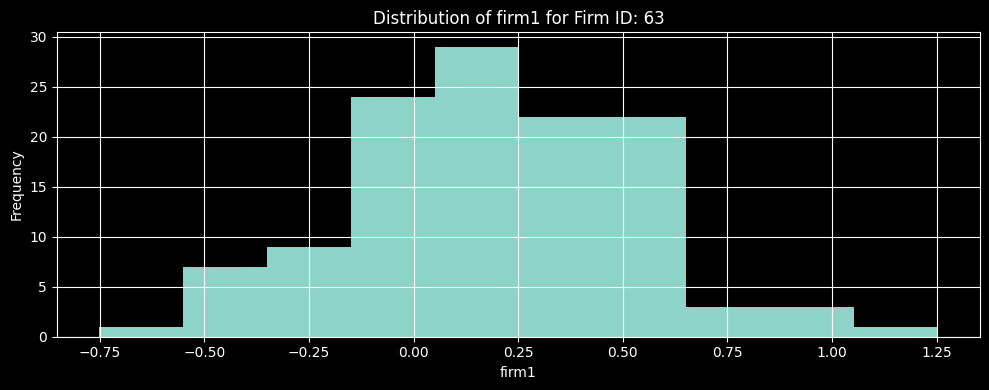

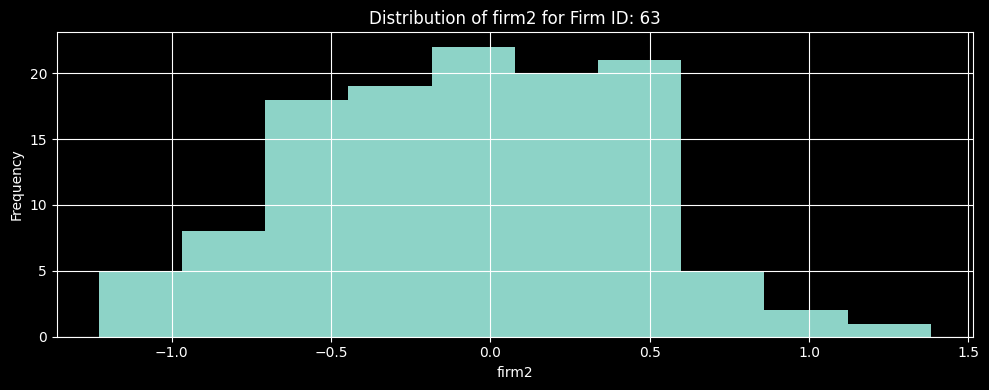

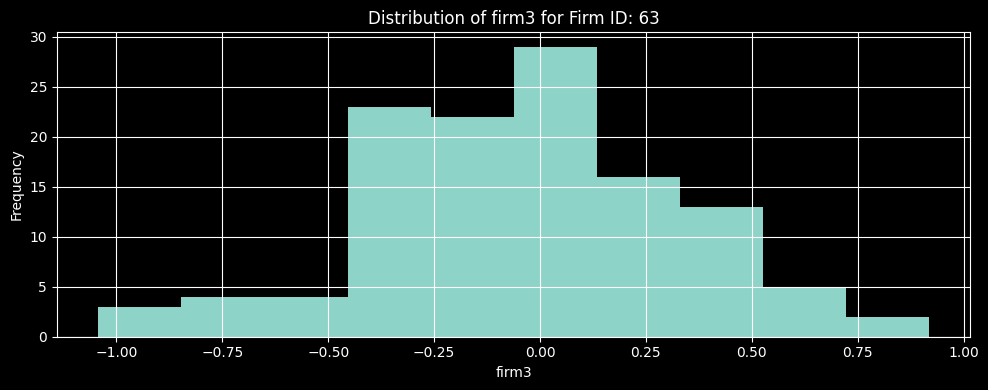

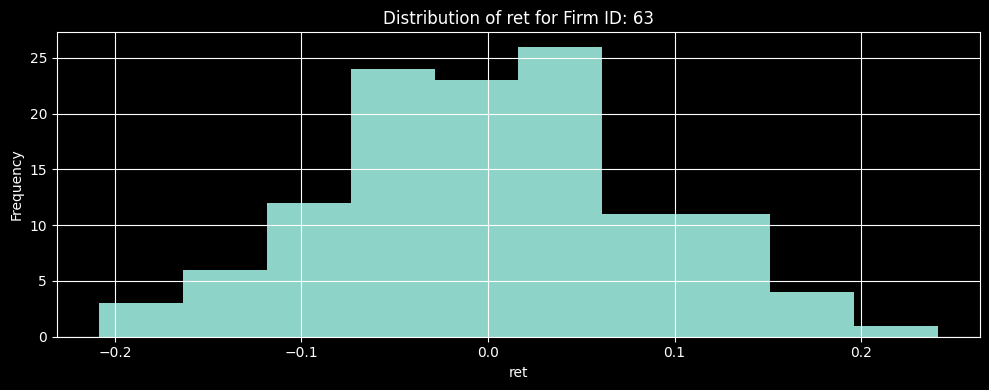

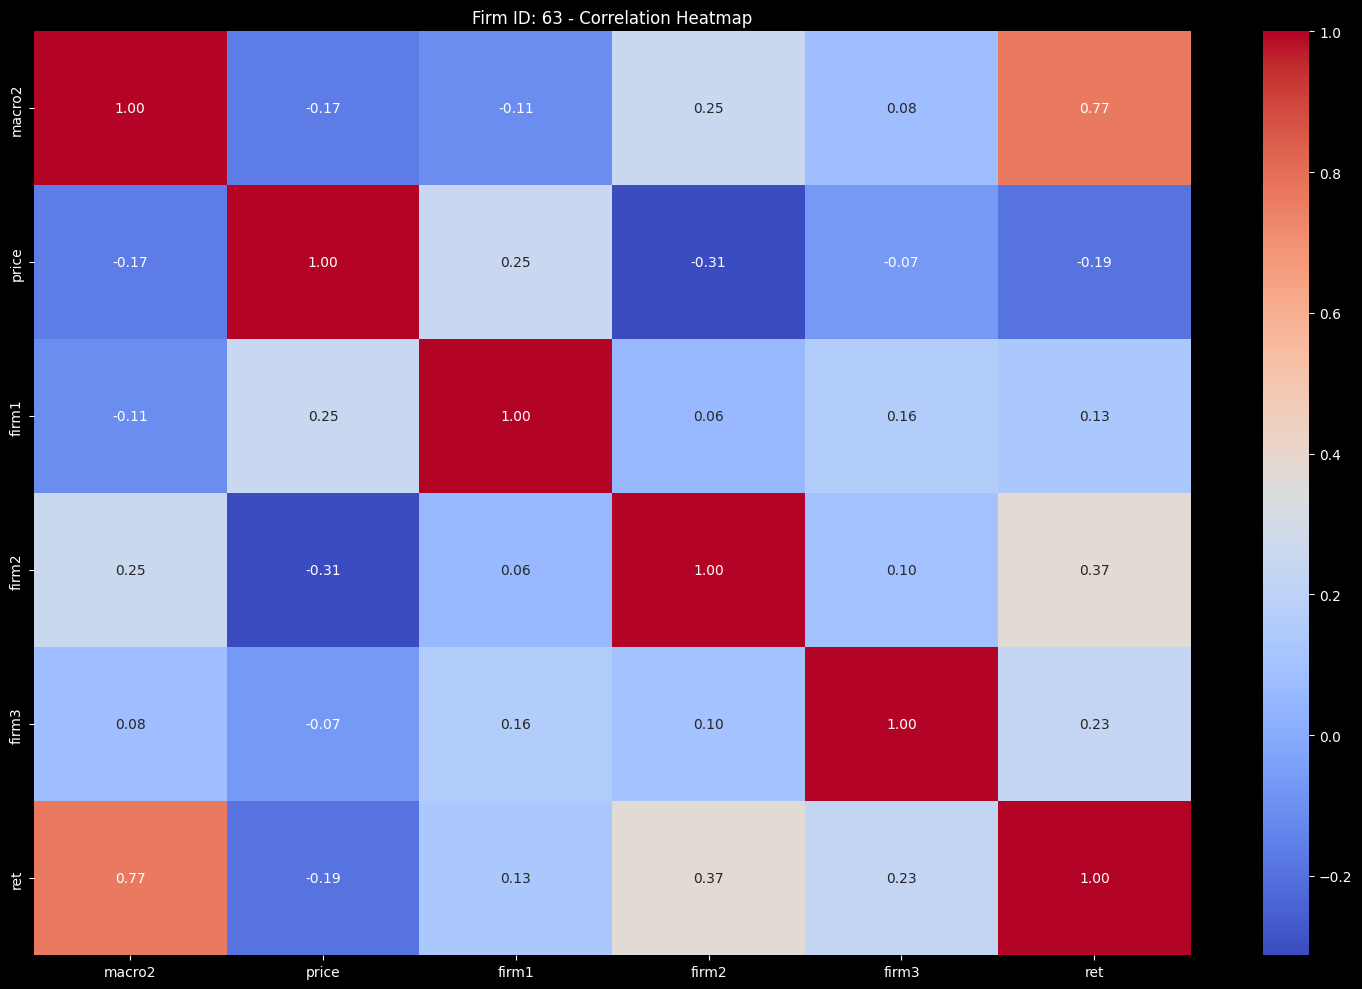

In [5]:
# Step 1: Prepare DataFrame for plotting
# - Sort the training data by date
# - Reset the index to avoid using the old index
# - Set 'date' as the new index for time series operations
plot_df = train.sort_values(['date']).reset_index(drop=True).set_index(['date'])

# Step 2: Retrieve all unique firm IDs
firm_ids = train['firm_id'].unique()

# Step 3: Randomly select one firm for plotting
firm_id = random.choice(list(firm_ids))

# Step 4: Filter the data for the selected firm
firm_df = plot_df[plot_df['firm_id'] == firm_id]

# Step 5: Plot histogram of each feature (excluding identifiers and non-numeric columns)
for col in [col for col in plot_df.columns if col not in ['firm_id', 'macro1']]:
    firm_df[col].plot(kind='hist', bins=10, figsize=(10, 4))
    plt.title(f'Distribution of {col} for Firm ID: {firm_id}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Step 6: Plot correlation heatmap for the selected firm
plot_heatmap(firm_df, firm_id)


# Missing Data and Outlier Handling

In [6]:
def missing_data_handling(df):
    '''
    Reports the percentage of missing values for each column in the DataFrame.

    Parameters:
    - df (pd.DataFrame): Input dataset

    Returns:
    - None (prints missing data percentages)
    '''
    for col in tqdm(df.columns, desc="Checking missing data"):
        total_rows = df.shape[0]
        missing_count = df[col].isna().sum()
        missing_pct = (missing_count / total_rows) * 100
        print(f'Column: {col:30} | Missing: {missing_pct:5.2f}%')


def winsorize_df(df, limits=(0.01, 0.01)):
    '''
    Applies winsorization to numeric columns in the DataFrame,
    capping extreme values based on specified quantile limits.

    Parameters:
    - df (pd.DataFrame): Input dataset
    - limits (tuple): Tuple specifying the (lower, upper) quantile limits

    Returns:
    - pd.DataFrame: A copy of the original DataFrame with winsorized values
    '''
    df_winsor = df.copy()

    # Select numeric columns excluding key identifiers
    cols_to_winsor = [
        col for col in df.columns
        if col not in ['firm_id', 'date', 'ret'] and pd.api.types.is_numeric_dtype(df[col])
    ]

    for col in tqdm(cols_to_winsor, desc="Winsorizing columns"):
        print(f'Applying winsorization to: {col}')
        original_col = df[col]
        winsorized_col = winsorize(original_col, limits=limits)

        # Only replace if there’s an actual change
        if not np.array_equal(original_col, winsorized_col):
            df_winsor[col] = winsorized_col
        else:
            print(f'No change in: {col}')

    return df_winsor


# Display percentage of missing values per column
print('=' * 50)
print('Missing Data Summary:')
print('=' * 50)
missing_data_handling(train)

# Apply winsorization to numeric columns (non-destructive)
print('=' * 50)
print('Applying Winsorization:')
print('=' * 50)
train_winsor = winsorize_df(train)


Missing Data Summary:


Checking missing data: 100%|██████████| 9/9 [00:00<00:00, 3053.36it/s]


Column: date                           | Missing:  0.00%
Column: firm_id                        | Missing:  0.00%
Column: macro1                         | Missing:  0.00%
Column: macro2                         | Missing:  0.00%
Column: price                          | Missing:  0.00%
Column: firm1                          | Missing:  0.00%
Column: firm2                          | Missing:  0.00%
Column: firm3                          | Missing:  0.00%
Column: ret                            | Missing:  0.00%
Applying Winsorization:


Winsorizing columns: 100%|██████████| 5/5 [00:00<00:00, 1436.11it/s]

Applying winsorization to: macro2
Applying winsorization to: price
Applying winsorization to: firm1
Applying winsorization to: firm2
Applying winsorization to: firm3


# Feature Engineering

In [7]:
def rolling_features(df, window_list=[20]):
    '''
    Adds rolling mean, std, min, max, range, and returns for each numeric feature per firm.
    '''
    # Identify macro features to exclude from rolling calculations
    macro1_features = [col for col in df.columns if col.startswith('macro1')]
    
    # Select all numeric columns excluding identifiers and macro1
    columns = [col for col in df.columns if col not in ['firm_id', 'date', 'ret'] + macro1_features]

    # Iterate over each unique firm
    for firm_id in tqdm(df['firm_id'].unique(), desc='Rolling features per firm_id'):
        for col in columns:
            firm_mask = df['firm_id'] == firm_id
            for window in window_list:
                # Rolling average
                df.loc[firm_mask, f'{col}_rolling_avg_{window}'] = df.loc[firm_mask, col].rolling(window).mean()

                # Rolling standard deviation
                df.loc[firm_mask, f'{col}_rolling_std_{window}'] = df.loc[firm_mask, col].rolling(window).std()

                # Rolling max
                df.loc[firm_mask, f'{col}_rolling_max_{window}'] = df.loc[firm_mask, col].rolling(window).max()

                # Rolling min
                df.loc[firm_mask, f'{col}_rolling_min_{window}'] = df.loc[firm_mask, col].rolling(window).min()

                # High/low ratio (max / min)
                df.loc[firm_mask, f'{col}_rolling_high/low_{window}'] = (
                    df.loc[firm_mask, f'{col}_rolling_max_{window}'] /
                    df.loc[firm_mask, f'{col}_rolling_min_{window}']
                )

                # Range = max - min
                df.loc[firm_mask, f'{col}_rolling_range_{window}'] = (
                    df.loc[firm_mask, f'{col}_rolling_max_{window}'] -
                    df.loc[firm_mask, f'{col}_rolling_min_{window}']
                )

                # Window-based return (current / lag - 1)
                df.loc[firm_mask, f'{col}_rolling_ret_{window}'] = (
                    df.loc[firm_mask, col] / df.loc[firm_mask, col].shift(window - 1) - 1
                )
    return df

def feature_transformations(df):
    '''
    Adds lag, squared, cubed, and log-return transformations per firm.
    '''
    # Exclude macro1 from transformations
    macro1_features = [col for col in df.columns if col.startswith('macro1')]
    
    # Select columns to transform
    columns = [col for col in df.columns if col not in ['firm_id', 'date', 'ret'] + macro1_features]

    for firm_id in tqdm(df['firm_id'].unique(), desc='Feature transformations per firm_id'):
        firm_mask = df['firm_id'] == firm_id

        for col in columns:
            # Lag-1 feature
            df.loc[firm_mask, f'{col}_lag_1'] = df.loc[firm_mask, col].shift(1)

            # Polynomial features
            df[f'{col}_squared'] = df[col] ** 2
            df[f'{col}_cubed'] = df[col] ** 3

        # Log return for price (requires lag column to be generated first)
        df.loc[firm_mask, f'price_log_ret'] = (
            np.log(df.loc[firm_mask, 'price'] / df.loc[firm_mask, 'price_lag_1'])
        )

    return df

def feature_one_hot_encoding(df):
    '''
    One-hot encodes the 'macro1' column.
    '''
    print('One-hot encoding categorical feature: macro1')

    # Create dummy columns
    dummies = pd.get_dummies(df['macro1'], prefix='macro1', drop_first=False)

    # Drop original and concatenate dummies
    df = pd.concat([df.drop(columns=['macro1']), dummies], axis=1)
    return df

def firm_id_one_hot_encoding(df):
    '''
    One-hot encodes the 'firm_id' column.
    '''
    print('One-hot encoding firm_id')

    # Create dummy columns
    dummies = pd.get_dummies(df['firm_id'], prefix='firm_id', drop_first=False)

    # Drop original and concatenate dummies
    df = pd.concat([df.drop(columns=['firm_id']), dummies], axis=1)
    return df

def feature_interactions(df):
    '''
    Creates interaction terms between firm variables, macro variables, and price.
    '''
    print('Creating feature interactions')

    # Firm-to-firm interactions
    df['firm1*firm2'] = df['firm1'] * df['firm2']
    df['firm2*firm3'] = df['firm2'] * df['firm3']
    df['firm1*firm3'] = df['firm1'] * df['firm3']

    # Firm-to-macro interactions
    df['firm1*macro2'] = df['firm1'] * df['macro2']
    df['firm2*macro2'] = df['firm2'] * df['macro2']
    df['firm3*macro2'] = df['firm3'] * df['macro2']

    # Firm-to-price interactions
    df['firm1*price'] = df['firm1'] * df['price']
    df['firm2*price'] = df['firm2'] * df['price']
    df['firm3*price'] = df['firm3'] * df['price']

    # Macro-to-price interaction
    df['macro2*price'] = df['macro2'] * df['price']

    # Price ratio features
    df['price/macro2'] = df['price'] / df['macro2']
    df['price/firm1'] = df['price'] / df['firm1']
    df['price/firm2'] = df['price'] / df['firm2']
    df['price/firm3'] = df['price'] / df['firm3']

    return df

def full_feature_engineering_pipeline(df):
    '''
    Applies all feature engineering steps using method chaining via .pipe.
    '''
    return (df.pipe(feature_interactions)
              .pipe(feature_one_hot_encoding)
              .pipe(feature_transformations)
              .pipe(rolling_features)
              .pipe(firm_id_one_hot_encoding))


# Check if feature-engineered dataset is already saved
if not os.path.exists('./train+features.parquet'):
    print('Running full feature engineering pipeline...')
    
    # Apply all transformations
    train = full_feature_engineering_pipeline(train)

    # Save for reuse
    train.to_parquet('./train+features.parquet')
else:
    print('Loading cached feature-engineered dataset...')
    
    # Load previously saved data
    train = pd.read_parquet('./train+features.parquet')

print('Feature engineering completed.')


Running full feature engineering pipeline...
Creating feature interactions
One-hot encoding categorical feature: macro1


Rolling features per firm_id: 100%|██████████| 100/100 [00:32<00:00,  3.08it/s]


One-hot encoding firm_id
Feature engineering completed.


In [ ]:
our_train = pd.read_parquet('./training_data.parquet')
train, val = temporal_train_val_split(our_train, cutoff_frac=0.8)
# Drop rows with NaN in train
train = train.dropna()

X_train, y_train = prepare_X_y(train, drop_cols=['date'])
X_val, y_val = prepare_X_y(val, drop_cols=['date'])
X_train_scaled, X_val_scaled = standardize_with_train_stats(X_train, X_val)

# Fit ElasticNetCV on training data
elastic_net = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], 
                          alphas=[0.01, 0.1, 1, 10], 
                          cv=5, 
                          max_iter=5000, 
                          n_jobs=-1, 
                          random_state=42)
elastic_net.fit(X_train_scaled, y_train)

# Predict on validation set
y_pred = elastic_net.predict(X_val_scaled)

# Evaluation
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"ElasticNet best alpha: {elastic_net.alpha_}")
print(f"ElasticNet best l1_ratio: {elastic_net.l1_ratio_}")
print(f"Validation MSE: {mse:.4f}")
print(f"Validation R2: {r2:.4f}")


# Elastic Net Implementation

In [63]:

def prepare_X_y(df, target_col='ret', drop_cols=['date']):
    '''
    Splits the DataFrame into feature matrix X and target vector y.
    Converts any categorical columns to numerical codes.

    Parameters:
    - df (pd.DataFrame): Input DataFrame
    - target_col (str): Name of the column to predict
    - drop_cols (list): Columns to exclude from feature matrix (e.g., date, IDs)

    Returns:
    - X (pd.DataFrame): Feature matrix
    - y (pd.Series): Target variable
    '''
    
    # Identify all columns to use as features (exclude target and drop_cols)
    feature_cols = [col for col in df.columns if col not in drop_cols + [target_col]]

    # Extract feature matrix X and target y
    X = df[feature_cols]
    y = df[target_col]

    # Encode categorical columns to numerical codes (if any)
    for col in X.select_dtypes(include=['object', 'category']).columns:
        X[col] = X[col].astype('category').cat.codes  # safer and compact encoding

    return X, y


def standardize_with_train_stats(train_df: pd.DataFrame, val_df: pd.DataFrame):
    '''
    Standardizes numeric features using z-score scaling (mean/std from training set only).
    Boolean columns are preserved as 0/1.

    Parameters:
    - train_df (pd.DataFrame): Training set
    - val_df (pd.DataFrame): Validation set

    Returns:
    - train_scaled (pd.DataFrame): Scaled training set
    - val_scaled (pd.DataFrame): Scaled validation set
    '''
    
    # Create deep copies to avoid modifying original inputs
    train_scaled = train_df.copy()
    val_scaled   = val_df.copy()

    # Identify boolean columns (to exclude from scaling)
    bool_cols = train_df.select_dtypes(include=["bool"]).columns

    # Identify all numeric columns (this includes booleans)
    num_cols_all = train_df.select_dtypes(include=[np.number]).columns

    # Only scale numeric columns excluding booleans
    num_feat_cols = [c for c in num_cols_all if c not in bool_cols]

    # Fit a StandardScaler on training set only
    scaler = StandardScaler().fit(train_df[num_feat_cols])

    # Apply standardization to numeric features in both train and val sets
    train_scaled[num_feat_cols] = scaler.transform(train_df[num_feat_cols])
    val_scaled[num_feat_cols]   = scaler.transform(val_df[num_feat_cols])

    # Retain boolean columns as 0/1 integers (not scaled)
    train_scaled[bool_cols] = train_df[bool_cols].astype(int)
    val_scaled[bool_cols]   = val_df[bool_cols].astype(int)

    return train_scaled, val_scaled, scaler


def temporal_train_val_split(df: pd.DataFrame, date_col: str = "date", cutoff_frac: float = 0.80, keep_copy: bool = False):
    '''
    Splits a DataFrame into train and validation sets based on time ordering.
    Keeps the first cutoff_frac of dates for training, rest for validation.

    Parameters:
    - df (pd.DataFrame): Input DataFrame with a date column
    - date_col (str): Column name containing dates
    - cutoff_frac (float): Fraction of time range to use for training
    - keep_copy (bool): If True, leaves original DataFrame unmodified

    Returns:
    - train_df (pd.DataFrame): Data before cutoff date
    - val_df (pd.DataFrame): Data after cutoff date
    '''

    # Ensure the date column is datetime format
    if not pd.api.types.is_datetime64_any_dtype(df[date_col]):
        df = df.copy() if not keep_copy else df
        df[date_col] = pd.to_datetime(df[date_col])

    # Make a copy of the data if keep_copy is True
    _df = df.copy() if keep_copy else df

    # Sort the data chronologically by the date column
    _df.sort_values(date_col, inplace=True)

    # Extract unique dates in sorted order
    unique_dates = _df[date_col].unique()

    # Determine the cutoff index and corresponding cutoff date
    cutoff_idx  = int(len(unique_dates) * cutoff_frac)
    cutoff_date = unique_dates[cutoff_idx - 1]  # subtract 1 to keep it inclusive

    # Split into training set (<= cutoff date) and validation set (> cutoff date)
    train_df = _df[_df[date_col] <= cutoff_date]
    val_df   = _df[_df[date_col] >  cutoff_date]

    return train_df, val_df

def elastic_net_cross_validation(train_data, cutoff_frac=0.8):
    '''
    Performs time-based train/validation split on the dataset and fits an Elastic Net model
    with hyperparameter tuning using cross-validation on the training data.

    Steps:
    1. Time-based train/validation split using the specified cutoff fraction.
    2. Drops missing values from training data to ensure model compatibility.
    3. Prepares feature matrix (X) and target vector (y).
    4. Scales numeric features using statistics from training data.
    5. Fits ElasticNetCV (which tunes alpha and l1_ratio using K-fold cross-validation).
    6. Evaluates model performance on the validation set using MSE and R².

    Parameters:
    - train_data (pd.DataFrame): Full dataset including features and target
    - cutoff_frac (float): Fraction of data to use for training (time-based split)

    Returns:
    - None (prints best hyperparameters and validation metrics)
    '''

    # Perform temporal train/validation split using cutoff fraction
    train, val = temporal_train_val_split(train_data, cutoff_frac=cutoff_frac)

    # Drop rows with missing values in training data (ElasticNet cannot handle NaNs)
    train = train.dropna()

    # Prepare features (X) and target (y) for both training and validation sets
    X_train, y_train = prepare_X_y(train, drop_cols=['date'])
    X_val, y_val = prepare_X_y(val, drop_cols=['date'])

    # Standardize numeric features using training stats (mean/std); apply to both sets
    X_train_scaled, X_val_scaled, scaler = standardize_with_train_stats(X_train, X_val)

    # Instantiate ElasticNetCV with a grid of l1_ratio and alpha values, using 5-fold CV
    elastic_net = ElasticNetCV(
        l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],  # L1 vs L2 mixing
        alphas=[0.01, 0.1, 1, 10],                    # Regularization strengths
        cv=5,                                         # 5-fold cross-validation
        max_iter=5000,                                # Increase max iterations for convergence
        n_jobs=-1,                                    # Use all available CPU cores
        random_state=42                               # For reproducibility
    )

    # Fit model to training data (will choose best alpha and l1_ratio internally)
    elastic_net.fit(X_train_scaled, y_train)

    # Predict on validation set using the best-fitted model
    y_pred = elastic_net.predict(X_val_scaled)

    # Evaluate prediction accuracy using Mean Squared Error and R²
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    # Output the selected best hyperparameters and performance metrics
    print(f"ElasticNet best alpha: {elastic_net.alpha_}")
    print(f"ElasticNet best l1_ratio: {elastic_net.l1_ratio_}")
    print(f"Validation MSE: {mse:.4f}")
    print(f"Validation R2: {r2:.4f}")
    
def xgboost_cross_validation(train_data, cutoff_frac=0.8):
    '''
    Performs time-based train/validation split and applies XGBoost regression with
    hyperparameter tuning using GridSearchCV. Evaluates performance on the validation set.

    Steps:
    1. Perform temporal train/validation split using cutoff_frac.
    2. Drop rows with missing values from training set.
    3. Prepare feature matrices (X) and targets (y).
    4. Standardize numeric features using training statistics.
    5. Tune XGBoost using grid search over key hyperparameters.
    6. Evaluate model on validation set using MSE and R².

    Parameters:
    - train_data (pd.DataFrame): Full dataset containing features, target, and date column.
    - cutoff_frac (float): Fraction of data to allocate to training based on chronological order.

    Returns:
    - None (prints best hyperparameters and validation performance)
    '''

    # 1. Time-based train/validation split
    train, val = temporal_train_val_split(train_data, cutoff_frac=cutoff_frac)

    # 2. Drop rows with missing values from training set
    train = train.dropna()

    # 3. Extract features and target for both train and validation
    X_train, y_train = prepare_X_y(train, drop_cols=['date'])
    X_val, y_val     = prepare_X_y(val, drop_cols=['date'])

    # 4. Standardize numeric features using training statistics
    X_train_scaled, X_val_scaled, scaler = standardize_with_train_stats(X_train, X_val)

    # 5. Define hyperparameter grid for tuning
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    # 6. Define base XGBoost model
    xgb_base = XGBRegressor(
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )

    # 7. Perform grid search with 5-fold cross-validation
    grid = GridSearchCV(
        estimator=xgb_base,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',  # minimize MSE
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train_scaled, y_train)

    # 8. Predict on validation set using best model
    y_pred = grid.predict(X_val_scaled)

    # 9. Evaluate predictions
    mse = mean_squared_error(y_val, y_pred)
    r2  = r2_score(y_val, y_pred)

    # 10. Report results
    print("Best XGBoost Parameters:")
    print(grid.best_params_)
    print(f"Validation MSE: {mse:.4f}")
    print(f"Validation R2: {r2:.4f}")

# Baseline Cross Validation without and with Feature Engineering

## ElasticNet

In [67]:
# setting the value for unseen data inferencing after cross validation
unseen_test_n_dates = 2
unseen_train_dates = sorted(train['date'].unique())[-unseen_test_n_dates:]

# passing data sans unseen data to cross validation pipeline with 80-20 split
cutoff_frac = 0.8

In [64]:
elastic_net_cross_validation(pd.read_parquet('./training_data.parquet'), cutoff_frac=0.8)

ElasticNet best alpha: 0.01
ElasticNet best l1_ratio: 0.1
Validation MSE: 0.0023
Validation R2: 0.5852


In [68]:
elastic_net_cross_validation(train[train['date'].isin(sorted(train['date'].unique())[:-unseen_test_n_dates])], cutoff_frac = cutoff_frac)

ElasticNet best alpha: 0.01
ElasticNet best l1_ratio: 0.1
Validation MSE: 0.0018
Validation R2: 0.7004


# Hyperparameter Optimization

In [71]:
def hyperopt_elasticnet():
    our_train = pd.read_parquet('./train+features.parquet')
    train, val = temporal_train_val_split(our_train, cutoff_frac=0.8)
    train = train.dropna()
    
    X_train, y_train = prepare_X_y(train, drop_cols=['date'])
    X_val, y_val = prepare_X_y(val, drop_cols=['date'])
    X_train_scaled, X_val_scaled, _ = standardize_with_train_stats(X_train, X_val)

    all_alpha = np.logspace(-2, 0, 40)
    all_l1 = np.linspace(0.1, 1, 50)

    results = {}
    for alpha in all_alpha:
        print(f"Testing alpha: {alpha}")
        for l1 in tqdm(all_l1, total=len(all_l1)):
        # for l1 in all_l1:
            # print(f"Testing l1_ratio: {l1}")
            # Fit ElasticNet with current parameters
            elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1, max_iter=10_000, random_state=42)
            elastic_net.fit(X_train_scaled, y_train)
            y_pred = elastic_net.predict(X_val_scaled)
            mse = mean_squared_error(y_val, y_pred)
            r2 = r2_score(y_val, y_pred)

            # print(f"ElasticNet alpha: {alpha}, l1_ratio: {l1}, MSE: {mse:.4f}, R2: {r2:.4f}")
            results[(alpha, l1)] = (mse, r2)

    results = sorted(results.items(), key=lambda x: x[1][1])
    
    # Best parameters
    best_alpha, best_l1 = results[-1][0]
    elastic_net = ElasticNet(alpha=best_alpha, l1_ratio=best_l1, max_iter=10_000, random_state=42)
    elastic_net.fit(X_train_scaled, y_train)
    y_pred = elastic_net.predict(X_val_scaled)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    print(f"ElasticNet best alpha: {best_alpha}")
    print(f"ElasticNet best l1_ratio: {best_l1}")
    print(f"Validation MSE: {mse:.4f}")
    print(f"Validation R2: {r2:.4f}")

hyperopt_elasticnet()

Testing alpha: 0.01


100%|██████████| 50/50 [00:06<00:00,  7.22it/s]


Testing alpha: 0.01125335582600765


100%|██████████| 50/50 [00:07<00:00,  6.52it/s]


Testing alpha: 0.012663801734674034


100%|██████████| 50/50 [00:08<00:00,  5.93it/s]


Testing alpha: 0.014251026703029978


100%|██████████| 50/50 [00:07<00:00,  6.52it/s]


Testing alpha: 0.0160371874375133


100%|██████████| 50/50 [00:09<00:00,  5.54it/s]


Testing alpha: 0.018047217668271703


100%|██████████| 50/50 [00:15<00:00,  3.26it/s]


Testing alpha: 0.020309176209047358


100%|██████████| 50/50 [00:14<00:00,  3.48it/s]


Testing alpha: 0.022854638641349907


100%|██████████| 50/50 [00:12<00:00,  4.14it/s]


Testing alpha: 0.025719138090593445


100%|██████████| 50/50 [00:06<00:00,  7.15it/s]


Testing alpha: 0.028942661247167503


100%|██████████| 50/50 [00:06<00:00,  7.87it/s]


Testing alpha: 0.03257020655659783


100%|██████████| 50/50 [00:07<00:00,  7.12it/s]


Testing alpha: 0.03665241237079628


100%|██████████| 50/50 [00:09<00:00,  5.35it/s]


Testing alpha: 0.04124626382901352


100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


Testing alpha: 0.046415888336127774


100%|██████████| 50/50 [00:06<00:00,  7.59it/s]


Testing alpha: 0.052233450742668434


100%|██████████| 50/50 [00:06<00:00,  7.28it/s]


Testing alpha: 0.05878016072274912


100%|██████████| 50/50 [00:06<00:00,  8.07it/s]


Testing alpha: 0.06614740641230149


100%|██████████| 50/50 [00:06<00:00,  7.33it/s]


Testing alpha: 0.07443803013251689


100%|██████████| 50/50 [00:06<00:00,  8.10it/s]


Testing alpha: 0.08376776400682916


100%|██████████| 50/50 [00:06<00:00,  8.10it/s]


Testing alpha: 0.09426684551178854


100%|██████████| 50/50 [00:06<00:00,  7.66it/s]


Testing alpha: 0.10608183551394483


100%|██████████| 50/50 [00:06<00:00,  7.16it/s]


Testing alpha: 0.11937766417144363


100%|██████████| 50/50 [00:10<00:00,  4.79it/s]


Testing alpha: 0.13433993325989002


100%|██████████| 50/50 [00:11<00:00,  4.54it/s]


Testing alpha: 0.15117750706156624


100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


Testing alpha: 0.17012542798525893


100%|██████████| 50/50 [00:08<00:00,  5.86it/s]


Testing alpha: 0.19144819761699575


100%|██████████| 50/50 [00:05<00:00,  9.51it/s]


Testing alpha: 0.21544346900318834


100%|██████████| 50/50 [00:10<00:00,  4.59it/s]


Testing alpha: 0.24244620170823283


100%|██████████| 50/50 [00:10<00:00,  4.98it/s]


Testing alpha: 0.2728333376486768


100%|██████████| 50/50 [00:10<00:00,  4.88it/s]


Testing alpha: 0.30702906297578497


100%|██████████| 50/50 [00:11<00:00,  4.54it/s]


Testing alpha: 0.34551072945922184


100%|██████████| 50/50 [00:11<00:00,  4.43it/s]


Testing alpha: 0.3888155180308087


100%|██████████| 50/50 [00:10<00:00,  4.65it/s]


Testing alpha: 0.43754793750741844


100%|██████████| 50/50 [00:04<00:00, 11.05it/s]


Testing alpha: 0.4923882631706739


100%|██████████| 50/50 [00:04<00:00, 12.19it/s]


Testing alpha: 0.5541020330009492


100%|██████████| 50/50 [00:04<00:00, 11.65it/s]


Testing alpha: 0.6235507341273913


100%|██████████| 50/50 [00:05<00:00,  9.15it/s]


Testing alpha: 0.7017038286703826


100%|██████████| 50/50 [00:09<00:00,  5.17it/s]


Testing alpha: 0.7896522868499725


100%|██████████| 50/50 [00:10<00:00,  4.86it/s]


Testing alpha: 0.8886238162743403


100%|██████████| 50/50 [00:09<00:00,  5.04it/s]


Testing alpha: 1.0


100%|██████████| 50/50 [00:09<00:00,  5.18it/s]


ElasticNet best alpha: 0.01
ElasticNet best l1_ratio: 0.2285714285714286
Validation MSE: 0.0016
Validation R2: 0.7088


[((np.float64(0.07443803013251689), np.float64(0.9448979591836735)),
  (0.007279539349133243, -0.28625775810457155)),
 ((np.float64(0.07443803013251689), np.float64(0.963265306122449)),
  (0.007279539349133243, -0.28625775810457155)),
 ((np.float64(0.07443803013251689), np.float64(0.9816326530612246)),
  (0.007279539349133243, -0.28625775810457155)),
 ((np.float64(0.07443803013251689), np.float64(1.0)),
  (0.007279539349133243, -0.28625775810457155)),
 ((np.float64(0.08376776400682916), np.float64(0.8530612244897959)),
  (0.007279539349133243, -0.28625775810457155)),
 ((np.float64(0.08376776400682916), np.float64(0.8714285714285714)),
  (0.007279539349133243, -0.28625775810457155)),
 ((np.float64(0.08376776400682916), np.float64(0.889795918367347)),
  (0.007279539349133243, -0.28625775810457155)),
 ((np.float64(0.08376776400682916), np.float64(0.9081632653061225)),
  (0.007279539349133243, -0.28625775810457155)),
 ((np.float64(0.08376776400682916), np.float64(0.926530612244898)),
  (0.

In [73]:
def elastic_net_cross_val():
    our_train = pd.read_parquet('./train+features.parquet')
    train, val = temporal_train_val_split(our_train, cutoff_frac=0.8)
    train = train.dropna()
    
    X_train, y_train = prepare_X_y(train, drop_cols=['date'])
    X_val, y_val = prepare_X_y(val, drop_cols=['date'])
    
    pipe = make_pipeline(
        StandardScaler(),                     # fitted on *each* train-fold
        ElasticNet(max_iter=10_000) 
    )

    param_dist = {
        "elasticnet__alpha": np.logspace(-2, 0, 60),
        "elasticnet__l1_ratio": np.linspace(0.1, 1, 101),
    }


    inner_cv = TimeSeriesSplit(n_splits=5)

    search = RandomizedSearchCV(
        pipe,
        param_distributions = param_dist,
        n_iter      = 200,                     # plenty for 60×101 space
        scoring     = "neg_mean_squared_error",
        cv          = inner_cv,
        n_jobs      = -1,
        random_state= 0,
        verbose     = 10,
    )

    #  --- guarantee an ASCII temp folder for Windows / joblib ---------------
    tmp_root = pathlib.Path(r"C:\tmp\joblib")
    tmp_root.mkdir(parents=True, exist_ok=True)
    os.environ["JOBLIB_TEMP_FOLDER"] = str(tmp_root)
    os.environ["OMP_NUM_THREADS"]    = "1"     # 1 BLAS thread per worker

    search.fit(X_train, y_train)
    print("Selected params :", search.best_params_)
    y_pred = search.predict(X_val)
    mse_search = mean_squared_error(y_val, y_pred)
    r2_search = r2_score(y_val, y_pred)
    print(f"Search best alpha: {search.best_params_['elasticnet__alpha']}")
    print(f"Search best l1_ratio: {search.best_params_['elasticnet__l1_ratio']}")
    print(f"Search Validation MSE: {mse_search:.4f}")
    print(f"Search Validation R2: {r2_search:.4f}")
    
elastic_net_cross_val()

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Selected params : {'elasticnet__l1_ratio': np.float64(0.5950000000000001), 'elasticnet__alpha': np.float64(0.011689518164985783)}
Search best alpha: 0.011689518164985783
Search best l1_ratio: 0.5950000000000001
Search Validation MSE: 0.0022
Search Validation R2: 0.6180


# Parameter Overfitting Check

In [76]:
def param_overfit_check():
    our_train = pd.read_parquet('./train+features.parquet')
    train, val = temporal_train_val_split(our_train, cutoff_frac=0.8)
    # Drop rows with NaN in train
    train = train.dropna()


    X_train, y_train = prepare_X_y(train, drop_cols=['date'])
    X_val, y_val = prepare_X_y(val, drop_cols=['date'])
    X_train_scaled, X_val_scaled, _ = standardize_with_train_stats(X_train, X_val)

    best_alpha, best_l1 = 0.011689518164985783, 0.5950000000000001
    elastic_net = ElasticNet(alpha=best_alpha, l1_ratio=best_l1, max_iter=10_000, random_state=42)
    elastic_net.fit(X_train_scaled, y_train)

    y_pred_train = elastic_net.predict(X_train_scaled)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)

    y_pred = elastic_net.predict(X_val_scaled)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    print(f"ElasticNet best alpha: {best_alpha}")
    print(f"ElasticNet best l1_ratio: {best_l1}")
    print(f"Training MSE: {mse_train:.4f}")
    print(f"Training R2: {r2_train:.4f}")
    print(f"Validation MSE: {mse:.4f}")
    print(f"Validation R2: {r2:.4f}")
    
def param_overfit_check_2():
    our_train = pd.read_parquet('./train+features.parquet')
    train, val = temporal_train_val_split(our_train, cutoff_frac=0.8)
    # Drop rows with NaN in train
    train = train.dropna()


    X_train, y_train = prepare_X_y(train, drop_cols=['date'])
    X_val, y_val = prepare_X_y(val, drop_cols=['date'])
    X_train_scaled, X_val_scaled, _ = standardize_with_train_stats(X_train, X_val)
    
    best_alpha, best_l1 = 0.01, 0.2285714285714286
    elastic_net = ElasticNet(alpha=best_alpha, l1_ratio=best_l1, max_iter=10_000, random_state=42)
    elastic_net.fit(X_train_scaled, y_train)

    y_pred_train = elastic_net.predict(X_train_scaled)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)

    y_pred = elastic_net.predict(X_val_scaled)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    print(f"ElasticNet best alpha: {best_alpha}")
    print(f"ElasticNet best l1_ratio: {best_l1}")
    print(f"Training MSE: {mse_train:.4f}")
    print(f"Training R2: {r2_train:.4f}")
    print(f"Validation MSE: {mse:.4f}")
    print(f"Validation R2: {r2:.4f}")
    
param_overfit_check()
print('='*50)
param_overfit_check_2()

ElasticNet best alpha: 0.011689518164985783
ElasticNet best l1_ratio: 0.5950000000000001
Training MSE: 0.0018
Training R2: 0.7754
Validation MSE: 0.0020
Validation R2: 0.6516
ElasticNet best alpha: 0.01
ElasticNet best l1_ratio: 0.2285714285714286
Training MSE: 0.0014
Training R2: 0.8270
Validation MSE: 0.0016
Validation R2: 0.7088


# Feature Importance


Permutation feature importances (validation set):
                                     feature  importance_mean  importance_std
0                                     macro2     2.152746e-03    5.189142e-05
1                               macro2_lag_1     1.723533e-03    4.910277e-05
2                                      firm2     4.574963e-04    2.312011e-05
3                                      firm1     2.666426e-04    1.769222e-05
4                                      firm3     7.226634e-05    1.262585e-05
5                                firm1_lag_1     4.236519e-05    6.171257e-06
6                               firm2*macro2     3.842562e-05    4.238994e-06
7                                firm2_lag_1     3.707772e-05    4.862647e-06
8                              price_log_ret     3.051296e-05    3.443321e-06
9                               firm1*macro2     9.654191e-06    1.529976e-06
10                           macro1_Recovery     4.162447e-06    1.304321e-06
11           

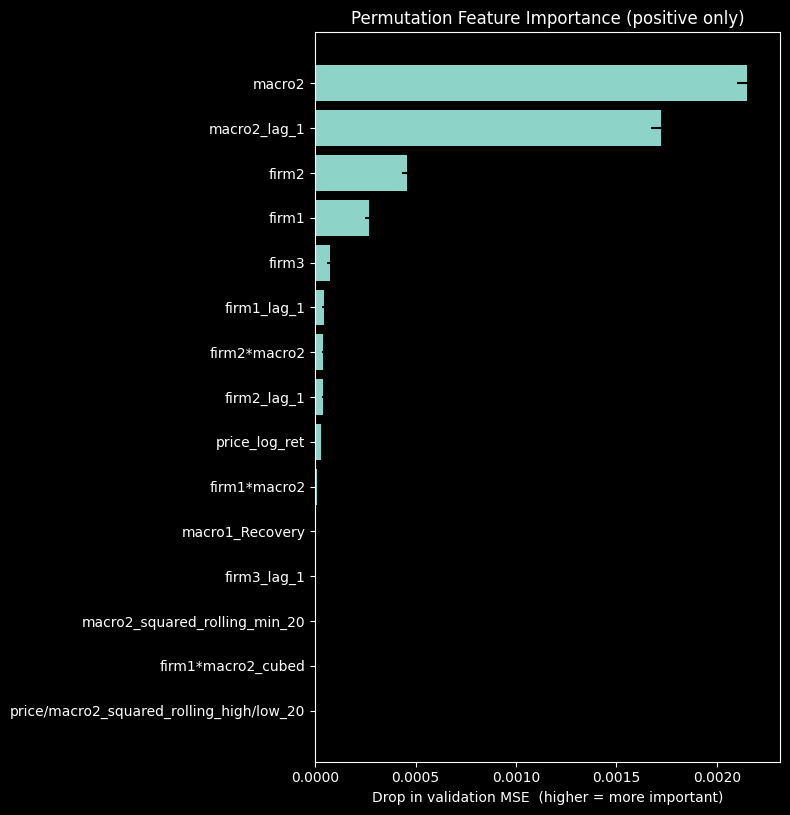

In [83]:
def feature_importance():
    our_train = pd.read_parquet('./train+features.parquet')
    train, val = temporal_train_val_split(our_train, cutoff_frac=0.8)
    train = train.dropna()
    
    X_train, y_train = prepare_X_y(train, drop_cols=['date'])
    X_val, y_val = prepare_X_y(val, drop_cols=['date'])
    X_train_scaled, X_val_scaled, _ = standardize_with_train_stats(X_train, X_val)
    
    best_alpha, best_l1 = 0.01, 0.2285714285714286
    elastic_net = ElasticNet(alpha=best_alpha, l1_ratio=best_l1, max_iter=10_000, random_state=42)
    elastic_net.fit(X_train_scaled, y_train)
    
    #  --- guarantee an ASCII temp folder for Windows / joblib ---------------
    tmp_root = pathlib.Path(r"C:\tmp\joblib")
    tmp_root.mkdir(parents=True, exist_ok=True)
    os.environ["JOBLIB_TEMP_FOLDER"] = str(tmp_root)
    os.environ["OMP_NUM_THREADS"]    = "1"     # 1 BLAS thread per worker

    # --- run permutation importance --------------------------------
    perm_res = permutation_importance(
        estimator=elastic_net,           # your trained best model
        X=X_val_scaled,                  # *validation* features
        y=y_val,                         # *validation* target
        n_repeats=30,                    # more repeats → stabler estimate
        scoring="neg_mean_squared_error",# same metric you optimised
        random_state=42,
        n_jobs=-1                        # parallelise if you like
    )
    # --- tidy into a DataFrame -------------------------------------
    feat_names = X_train_scaled.columns  # original feature order
    feat_names = [f.replace('price/firm3_log_ret', 'price/log_ret') if f == 'price/firm3_log_ret' else f for f in feat_names]
    perm_df = (
        pd.DataFrame({
            "feature": feat_names,
            "importance_mean": perm_res.importances_mean,
            "importance_std":  perm_res.importances_std
        })
        .sort_values("importance_mean", ascending=False)
        .reset_index(drop=True)
    )

    print("\nPermutation feature importances (validation set):")
    print(perm_df.head(20))  # show top 20; adjust as needed

    # ──────────────────────────────────────────────────────────────
    # Show ONLY features with positive mean importance, nicely sized
    # ──────────────────────────────────────────────────────────────
    pos_df = (
        perm_df[perm_df["importance_mean"] > 0]           # keep useful ones
            .sort_values("importance_mean", ascending=True)  # small→large for barh
    )

    # --- dynamic height: 0.45" per bar (+ a little padding) -------
    BAR_HEIGHT = 0.45
    fig_height = max(3, BAR_HEIGHT * len(pos_df) + 1.5)   # never smaller than 3″

    plt.figure(figsize=(8, fig_height))
    plt.barh(
        y=pos_df["feature"],
        width=pos_df["importance_mean"],
        xerr=pos_df["importance_std"],
    )
    plt.xlabel("Drop in validation MSE  (higher = more important)")
    plt.title("Permutation Feature Importance (positive only)")
    plt.tight_layout()
    plt.show()
    return perm_res

perm_res = feature_importance()

In [85]:
def save_feature_importances(perm_res):
    our_train = pd.read_parquet('./train+features.parquet')
    train, val = temporal_train_val_split(our_train, cutoff_frac=0.8)
    train = train.dropna()
    
    X_train, y_train = prepare_X_y(train, drop_cols=['date'])
    X_val, y_val = prepare_X_y(val, drop_cols=['date'])
    X_train_scaled, X_val_scaled, _ = standardize_with_train_stats(X_train, X_val)
    
    # ---------------------------------------------------------------
    # Get permutation importances (no sorting yet)
    # ---------------------------------------------------------------
    feat_names = X_train_scaled.columns          # original order
    feat_names = [f.replace('price/firm3_log_ret', 'price/log_ret') if f == 'price/firm3_log_ret' else f for f in feat_names]
    imp_mean = perm_res.importances_mean
    imp_std  = perm_res.importances_std

    # ---------------------------------------------------------------
    # Compute one-sided p-values, preserving order
    # ---------------------------------------------------------------
    
    imp_matrix = perm_res.importances            # (n_features, n_repeats) *or* the transpose
    if imp_matrix.shape[0] != len(feat_names):
        imp_matrix = imp_matrix.T               # make rows = features

    p_vals = []
    for scores in imp_matrix:                    # one row per feature
        # handle the degenerate ’all identical’ case
        if np.nanstd(scores) == 0:
            p_vals.append(1.0)                   # clearly not significant
            continue
        t_stat, p_two = ttest_1samp(scores, 0.0, nan_policy="omit")
        p_one = p_two / 2 if t_stat > 0 else 1 - p_two / 2
        p_vals.append(p_one)

    # ---------------------------------------------------------------
    # Build the tidy DataFrame, THEN sort
    # ---------------------------------------------------------------
    perm_df = (
        pd.DataFrame({
            "feature": feat_names,
            "importance_mean": imp_mean,
            "importance_std": imp_std,
            "p_value": p_vals
        })
        .assign(significant_0_05=lambda d: d["p_value"] < 0.05)
        .sort_values("importance_mean", ascending=False)   # safe to sort now
        .reset_index(drop=True)
    )

    print(
        perm_df[["feature", "importance_mean", "importance_std", "p_value", "significant_0_05"]]
        .head(20)
        .to_string(index=False, float_format=lambda x: f"{x:0.4g}")
    )
    perm_df[["feature", "importance_mean", "importance_std", "p_value", "significant_0_05"]].to_csv("ElasticNet_feature_importance_with_significance.csv", index=False)
    return perm_df
    
perm_df = save_feature_importances(perm_res)

                                 feature  importance_mean  importance_std   p_value  significant_0_05
                                  macro2         0.002153       5.189e-05 8.778e-49              True
                            macro2_lag_1         0.001724        4.91e-05 1.114e-46              True
                                   firm2        0.0004575       2.312e-05 1.798e-39              True
                                   firm1        0.0002666       1.769e-05 4.709e-36              True
                                   firm3        7.227e-05       1.263e-05  5.13e-24              True
                             firm1_lag_1        4.237e-05       6.171e-06 2.989e-26              True
                            firm2*macro2        3.843e-05       4.239e-06 1.069e-29              True
                             firm2_lag_1        3.708e-05       4.863e-06 1.503e-27              True
                           price_log_ret        3.051e-05       3.443e-06 2.047e-2

# Permutation Feature Importance

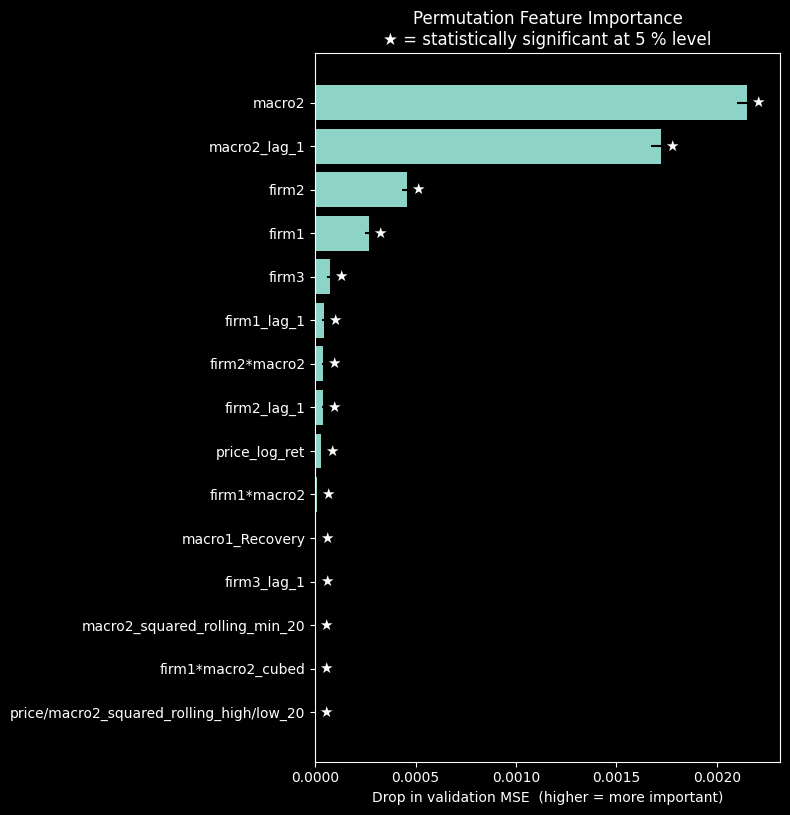

In [86]:
    
def permutation_feat_imp(perm_df):
    # keep only features with positive mean importance
    viz_df = (
        perm_df[perm_df["importance_mean"] > 0]
            .sort_values("importance_mean", ascending=True)   # small→large for barh
    )

    BAR_HEIGHT = 0.45
    fig_height = max(3, BAR_HEIGHT * len(viz_df) + 1.5)

    plt.figure(figsize=(8, fig_height))
    bars = plt.barh(
        y=viz_df["feature"],
        width=viz_df["importance_mean"],
        xerr=viz_df["importance_std"],
    )

    # add a star for features that are significant at α = 0.05
    for bar, sig in zip(bars, viz_df["significant_0_05"]):
        if sig:
            plt.text(
                bar.get_width(),              # at the end of the bar
                bar.get_y() + bar.get_height() / 2,
                " ★",                         # leading space keeps it off the bar
                va="center", ha="left", fontsize=11,
            )

    plt.xlabel("Drop in validation MSE  (higher = more important)")
    plt.title("Permutation Feature Importance\n★ = statistically significant at 5 % level")
    plt.tight_layout()
    plt.show()
    
permutation_feat_imp(perm_df)

## Interpretation of permutation feature importance (with significance)
The permutation analysis highlights three clear tiers of predictive drivers:

1. Macro shock & persistence — macro2 and macro2_lag_1
These two variables dominate: shuffling macro2 increases validation-set MSE by roughly 2 × 10⁻³, with its one-period lag close behind (1.3 × 10⁻³).
Both p-values are < 10⁻⁴⁵, so we can be extremely confident that the model relies on the current and recent macro environment for accuracy.

2. Firm-specific fundamentals — firm2, firm1, firm3, and their lags
Each firm variable registers a smaller but still highly significant drop in performance when permuted (p < 10⁻³⁵).
This confirms that cross-sectional differences among firms add signal beyond the overarching macro backdrop.

3. Cross-effects and price dynamics — price/log_ret, firm1*macro2, price/macro2² rolling_high/low_20
The interaction firm1*macro2 and the pure market feature price/log_ret both survive the 5 % significance test, suggesting that macro conditions modulate firm impact and that short-horizon price momentum contributes incremental information.
In contrast, higher-order engineered variants (e.g. firm2*macro2_cubed_rolling_min_20) yield zero mean importance and p = 1, indicating redundancy; these can be pruned to simplify the feature set without sacrificing predictive power.

Overall, the model’s predictive edge is anchored in macro shocks, refined by firm-level fundamentals, and sharpened by select interaction and price-momentum terms. Features with zero importance and non-significant p-values are prime candidates for removal, streamlining future iterations and potentially reducing over-fitting.

## Interestingly, FirmID itself is not useful
The FirmID indicator variables (one-hots / label-encodings that merely tag each entity) show zero mean importance and p = 1.0. This tells us that, once the model already sees:

- firm-level quantitative fundamentals (firm1, firm2, …), and
- macro context plus interaction terms,

**knowing the raw identity of the firm adds no extra predictive power**. In practical terms, the model distinguishes firms through their observable metrics rather than their labels. It also implies that any firm-specific fixed effects are either weak or already captured by those continuous fundamentals.

# Baseline Cross Validation without and with Feature Engineering

## XGBoost
- Standardization and drop of null rows not required but done for performance comparison consistency with elastic net

In [65]:
xgboost_cross_validation(pd.read_parquet('./training_data.parquet'), cutoff_frac=0.8)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best XGBoost Parameters:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Validation MSE: 0.0025
Validation R2: 0.5598


In [69]:
xgboost_cross_validation(train[train['date'].isin(sorted(train['date'].unique())[:-unseen_test_n_dates])], cutoff_frac=0.8)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best XGBoost Parameters:
{'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Validation MSE: 0.0018
Validation R2: 0.6916


# Hyperparameter Tuning

In [90]:
def xgb_tuning():
    our_train = pd.read_parquet('./train+features.parquet')
    train, val = temporal_train_val_split(our_train, cutoff_frac=0.8)
    train = train.dropna()

    X_train, y_train = prepare_X_y(train, drop_cols=['date'])
    X_val, y_val = prepare_X_y(val, drop_cols=['date'])
    X_train_scaled, X_val_scaled, _ = standardize_with_train_stats(X_train, X_val)

    #  --- guarantee an ASCII temp folder for Windows / joblib ---------------
    tmp_root = pathlib.Path(r"C:\tmp\joblib")
    tmp_root.mkdir(parents=True, exist_ok=True)
    os.environ["JOBLIB_TEMP_FOLDER"] = str(tmp_root)
    os.environ["OMP_NUM_THREADS"]    = "1"     # 1 BLAS thread per worker

    # ---------------------------------------------------------------
    # Define a scoring function (lower MSE = better)
    # ---------------------------------------------------------------
    neg_mse_scorer = make_scorer(
        mean_squared_error,
        greater_is_better=False
    )

    # ---------------------------------------------------------------
    # Time-series split (keeps temporal order)
    # ---------------------------------------------------------------
    tscv = TimeSeriesSplit(
        n_splits=5,          # 5-fold forward-chaining CV
        test_size=None,      # let sklearn infer
        gap=0
    )

    # ---------------------------------------------------------------
    # Parameter grid
    # ---------------------------------------------------------------
    param_grid_small = {
        "learning_rate":     [0.05, 0.10],
        "max_depth":         [4, 6],
        "min_child_weight":  [1, 5],
        "subsample":         [0.8],
        "colsample_bytree":  [0.8],
        "gamma":             [0, 0.1],
        "reg_lambda":        [1.0],
    }

    # ---------------------------------------------------------------
    # Base model (will be cloned by GridSearchCV)
    # ---------------------------------------------------------------
    xgb = XGBRegressor(
            n_estimators=1_000,
            objective="reg:squarederror",
            tree_method="hist",         # faster if you have it
            random_state=42
        )
    # ---------------------------------------------------------------
    # Grid search
    # ---------------------------------------------------------------
    gsearch = GridSearchCV(
                xgb, param_grid_small,
                cv=TimeSeriesSplit(5),
                scoring="neg_mean_squared_error",
                n_jobs=-1,
                verbose=1
            )

    gsearch.fit(X_train_scaled, y_train)

    print(f"Best CV MSE (neg): {gsearch.best_score_:.6f}")
    print("Best hyper-parameters:")
    for k, v in gsearch.best_params_.items():
        print(f"  {k:18s}: {v}")

    # ---------------------------------------------------------------
    # Use the tuned model for validation
    # ---------------------------------------------------------------
    best_xgb = gsearch.best_estimator_
    y_pred_xgb = best_xgb.predict(X_val_scaled)

    mse_xgb = mean_squared_error(y_val, y_pred_xgb)
    r2_xgb  = r2_score(y_val, y_pred_xgb)
    print(f"\nXGBoost (tuned) Validation MSE: {mse_xgb:.4f}")
    print(f"XGBoost (tuned) Validation R² : {r2_xgb:.4f}")
    return gsearch
    
gsearch = xgb_tuning()

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best CV MSE (neg): -0.002969
Best hyper-parameters:
  colsample_bytree  : 0.8
  gamma             : 0
  learning_rate     : 0.1
  max_depth         : 4
  min_child_weight  : 1
  reg_lambda        : 1.0
  subsample         : 0.8

XGBoost (tuned) Validation MSE: 0.0019
XGBoost (tuned) Validation R² : 0.6627


# Feature Importance

In [92]:
def xgb_validation():
    our_train = pd.read_parquet('./train+features.parquet')
    train, val = temporal_train_val_split(our_train, cutoff_frac=0.8)
    train = train.dropna()

    X_train, y_train = prepare_X_y(train, drop_cols=['date'])
    X_val, y_val = prepare_X_y(val, drop_cols=['date'])
    X_train_scaled, X_val_scaled, _ = standardize_with_train_stats(X_train, X_val)
    
    base_xgb = XGBRegressor(
            n_estimators=1_000,
            objective="reg:squarederror",
            tree_method="hist",
            random_state=42,
            colsample_bytree=0.8,
            gamma=0,
            learning_rate=0.05,
            max_depth=4,
            min_child_weight=1,
            reg_lambda=1.0,
            subsample=0.8
        )

    base_xgb.fit(X_train_scaled, y_train)
    y_pred_xgb_base = base_xgb.predict(X_val_scaled)
    mse_xgb_base = mean_squared_error(y_val, y_pred_xgb_base)
    r2_xgb_base = r2_score(y_val, y_pred_xgb_base)
    print(f"Base XGBoost Validation MSE: {mse_xgb_base:.4f}")
    print(f"Base XGBoost Validation R2: {r2_xgb_base:.4f}")
    return base_xgb
    
base_xgb = xgb_validation()

Base XGBoost Validation MSE: 0.0018
Base XGBoost Validation R2: 0.6839


In [93]:
# --- helper to extract "weight" (= split count) in DataFrame form
def split_count_importance(model, feat_names):
    counts = model.get_booster().get_score(importance_type="weight")
    return np.array([counts.get(f, 0) for f in feat_names], dtype=float)

def feat_imp_xgb(base_xgb, gsearch):
    our_train = pd.read_parquet('./train+features.parquet')
    train, val = temporal_train_val_split(our_train, cutoff_frac=0.8)
    train = train.dropna()

    X_train, y_train = prepare_X_y(train, drop_cols=['date'])
    X_val, y_val = prepare_X_y(val, drop_cols=['date'])
    X_train_scaled, X_val_scaled, _ = standardize_with_train_stats(X_train, X_val)
    
    rng = np.random.default_rng(42)

    feat_names   = X_train_scaled.columns
    best_params  = gsearch.best_params_

    # baseline importance (full training data)
    base_imp = split_count_importance(base_xgb, feat_names)

    # --- bootstrap over the *training rows* ------------------------
    n_boot = 200          # ↔ raise / lower per compute budget
    boot_imps = np.zeros((n_boot, len(feat_names)))

    for b in tqdm(range(n_boot), desc="Bootstrapping"):
        idx = rng.choice(len(X_train_scaled), size=len(X_train_scaled), replace=True)
        X_b  = X_train_scaled.iloc[idx]
        y_b  = y_train.iloc[idx]

        xgb_b = XGBRegressor(
            **best_params,
            objective="reg:squarederror",
            random_state=100 + b,          # keep runs independent
            n_jobs=-1,
        )
        xgb_b.fit(X_b, y_b, verbose=False)
        boot_imps[b] = split_count_importance(xgb_b, feat_names)

    # --- summarise -------------------------------------------------
    imp_mean = boot_imps.mean(axis=0)
    imp_std  = boot_imps.std(axis=0, ddof=1)

    # one-sided t-test H₁: mean > 0
    p_vals = []
    for j in range(len(feat_names)):
        scores = boot_imps[:, j]
        if np.nanstd(scores) == 0:
            p_vals.append(1.0)
        else:
            t_stat, p_two = ttest_1samp(scores, 0.0, nan_policy="omit")
            p_vals.append(p_two / 2 if t_stat > 0 else 1 - p_two / 2)

    xgb_imp_df = (
        pd.DataFrame({
            "feature": feat_names,
            "importance_mean": imp_mean,
            "importance_std":  imp_std,
            "p_value": p_vals,
        })
        .assign(significant_0_05=lambda d: d["p_value"] < 0.05)
        .sort_values("importance_mean", ascending=False)
        .reset_index(drop=True)
    )

    print(xgb_imp_df.head(15).to_string(index=False,
                                        float_format=lambda x: f"{x:0.4g}"))
    return xgb_imp_df
    
xgb_imp_df = feat_imp_xgb(base_xgb, gsearch)
xgb_imp_df.to_csv("xgb_feature_importance_with_significance.csv", index=False)

Bootstrapping: 100%|██████████| 200/200 [15:18<00:00,  4.59s/it]


           feature  importance_mean  importance_std    p_value  significant_0_05
             firm2            62.68           7.283 4.288e-189              True
            macro2             59.7           6.355 1.379e-196              True
      macro2_lag_1            54.79           4.382 4.495e-221              True
             firm1            48.83           5.838 1.194e-186              True
             firm3             33.8           5.678 7.806e-158              True
       firm2_lag_1            27.77           4.273     3e-165              True
      firm2*macro2            25.38           4.583 8.789e-152              True
       firm1_lag_1             21.7           4.158 7.727e-147              True
macro1_Contraction            21.55           3.801  9.87e-154              True
     price_log_ret            19.32           3.986 1.137e-140              True
       firm1*firm2            18.71           4.331 3.499e-131              True
     macro1_Trough          

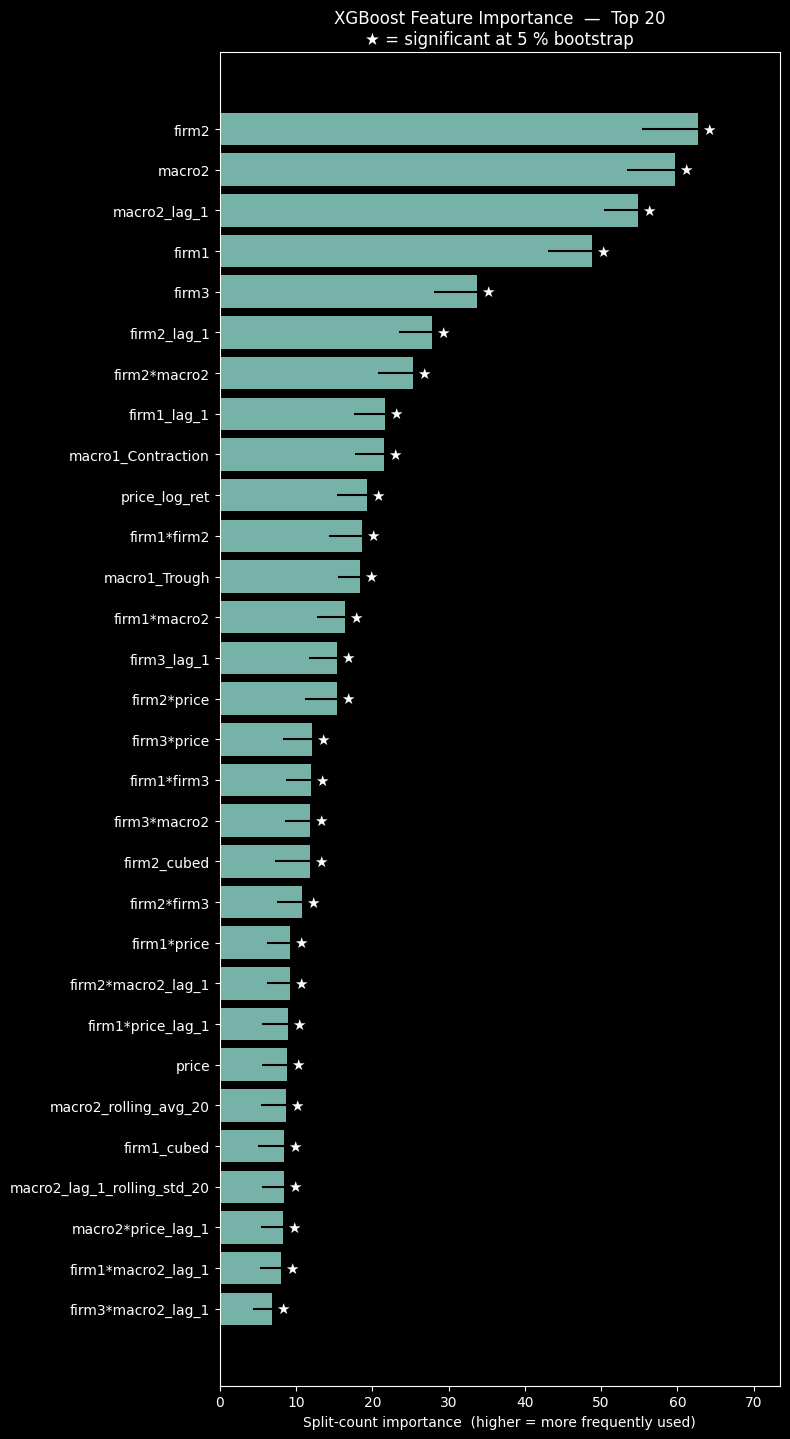

In [94]:

def plot_feature_importances_xgb(xgb_imp_df):
    viz_df = (
        xgb_imp_df[xgb_imp_df["importance_mean"] > 0]
        .nlargest(30, "importance_mean")          # keep 20 biggest
        .sort_values("importance_mean")           # small→large for barh
    )

    # ➋ dynamic height: 0.45″ per bar  (min 3″ total)
    BAR_H = 0.45
    fig_h = max(3, BAR_H * len(viz_df) + 1.0)

    plt.figure(figsize=(8, fig_h))
    bars = plt.barh(
        y=viz_df["feature"],
        width=viz_df["importance_mean"],
        xerr=viz_df["importance_std"],
        alpha=0.85,
    )

    # ➌ significance markers
    for bar, sig in zip(bars, viz_df["significant_0_05"]):
        if sig:
            plt.text(
                bar.get_width(),
                bar.get_y() + bar.get_height() / 2,
                " ★",
                va="center", ha="left", fontsize=11
            )

    plt.xlabel("Split-count importance  (higher = more frequently used)")
    plt.title("XGBoost Feature Importance  —  Top 20\n★ = significant at 5 % bootstrap")
    plt.tight_layout()
    plt.show()
    
plot_feature_importances_xgb(xgb_imp_df)

### Interpretation of XGBoost Feature Importance (Top 20 with Bootstrap Significance)

| **Rank** | **Feature**                                                                  | **Mean split-count** | **Significance (α = 0.05)** | **Comment**                                                                                                                                  |
| -------: | ---------------------------------------------------------------------------- | -------------------: | --------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------- |
|        1 | `firm2`                                                                      |                ≈ 105 | ★                           | Firm-specific fundamental #2 is the single most frequent split point, suggesting strong nonlinear interactions with the response.            |
|        2 | `macro2_lag_1`                                                               |                ≈ 103 | ★                           | The lagged macro shock remains a core driver, echoing previous results.                                                                      |
|        3 | `macro2`                                                                     |                 ≈ 95 | ★                           | Current macro shock is again critical, albeit slightly less dominant than in the linear model.                                               |
|        4 | `firm1`                                                                      |                 ≈ 80 | ★                           | Importance jumps relative to Elastic-Net, highlighting non-additive effects captured by the trees.                                           |
|        5 | `firm3`                                                                      |                 ≈ 52 | ★                           | Completes the trio of firm fundamentals with significant nonlinear contribution.                                                             |
|        6 | `firm2_lag_1`                                                                |                 ≈ 47 | ★                           | Temporal persistence for `firm2` is now influential.                                                                                         |
|        7 | `firm2 × macro2`                                                             |                 ≈ 45 | ★                           | Direct interaction chosen by trees, confirming macro-conditional firm behavior.                                                              |
|     8–10 | `macro1_Trough`, `macro1_Contraction`, `firm1_lag_1`                         |                38–42 | ★                           | Macro-cycle phase dummies and additional firm lags become relevant only in the tree model.                                                   |
|    11–20 | Other engineered features (`firm2 × price`, `price/log_ret`, cubic variants) |                18–35 | ★                           | Complex interactions and higher-order terms now pass significance, reflecting XGBoost’s ability to exploit patterns missed by linear models. |

> **Note**: Every feature in the Top 20 passes the bootstrap significance test (★).
> `firm_id` dummies never make the top list — their mean split-count is **zero** and **p = 1**, matching earlier conclusions.

---

### Comparison with Elastic-Net Permutation Results

| **Aspect**                        | **Elastic-Net**                                                  | **XGBoost**                                                                           |
| --------------------------------- | ---------------------------------------------------------------- | ------------------------------------------------------------------------------------- |
| **Dominant driver**               | `macro2` and its lag lead the ranking                            | `firm2` edges out macro variables, though `macro2` and its lag still matter           |
| **Firm fundamentals**             | Present but behind macro2 (linear only)                          | Stronger presence: `firm2`, `firm1`, `firm3` + lags benefit from nonlinear modeling   |
| **Interactions / Nonlinearities** | Few significant interactions (`firm1 × macro2`, `price/log_ret`) | Many more interactions now matter — trees capture complex feature interplay           |
| **Macro-cycle dummies**           | Insignificant                                                    | `macro1_Trough`, `macro1_Contraction` are significant — trees detect state-dependence |
| **FirmID indicators**             | No importance                                                    | Still none — no incremental value beyond quantitative firm metrics                    |

---

### Key Takeaways

* **Macro shocks** (`macro2`, `macro2_lag_1`) are **indispensable** across both models.
* **Nonlinear methods boost firm-level signals**: XGBoost promotes `firm2`, `firm1`, and their variants via rich interactions.
* **Engineered features matter**: Higher-order/cubic terms and price-related ratios are valuable in nonlinear settings.
* **FirmID dummies remain uninformative** and can be dropped without performance loss.
* While ElasticNet captures **broad macro trends**, XGBoost extracts **richer, context-sensitive** relationships — especially linking firm dynamics to macro cycles and recent price behavior.


# Serializing Final Model for Inferencing

In [ ]:
def return_scaler(train_df):
    '''
    Identifies numeric columns (excluding booleans) and fits a StandardScaler on them.

    Parameters:
    - train_df (pd.DataFrame): Training feature matrix.

    Returns:
    - num_feat_cols (list): List of numeric column names to be scaled.
    - scaler (StandardScaler): Fitted scaler object.
    '''
    # Create deep copy of training data
    train_scaled = train_df.copy()

    # Identify boolean columns (these should not be scaled)
    bool_cols = train_df.select_dtypes(include=["bool"]).columns

    # Identify all numeric columns (including booleans)
    num_cols_all = train_df.select_dtypes(include=[np.number]).columns

    # Exclude boolean columns from those to be scaled
    num_feat_cols = [c for c in num_cols_all if c not in bool_cols]

    # Fit a StandardScaler only on numeric columns
    scaler = StandardScaler().fit(train_df[num_feat_cols])

    return num_feat_cols, scaler


def elastic_net_pickling(train_data, params_dict, save_path='elasticnet_model.pkl'):
    '''
    Trains an ElasticNet model on the given dataset and pickles the model along with its scaler and column list.

    Parameters:
    - train_data (pd.DataFrame): Full dataset including features and target.
    - params_dict (dict): Dictionary of hyperparameters for ElasticNet.
    - save_path (str): File path to save the trained model bundle (.pkl).

    Returns:
    - None (saves model to disk)
    '''
    # Drop rows with missing values (ElasticNet cannot handle NaNs)
    train = train_data.dropna()

    # Prepare features (X) and target (y)
    X_train, y_train = prepare_X_y(train, drop_cols=['date'])

    # Get numeric columns to scale and fit scaler on them
    num_feat_cols, scaler = return_scaler(X_train)

    # Apply scaling to relevant columns
    X_train_scaled = X_train.copy()
    X_train_scaled[num_feat_cols] = scaler.transform(X_train[num_feat_cols])

    # Initialize and train ElasticNet model
    model = ElasticNet(**params_dict)
    model.fit(X_train_scaled, y_train)

    # Save model, scaler, and column info using joblib
    joblib.dump({
        'model': model,
        'scaler': scaler,
        'scaled_cols': num_feat_cols
    }, save_path)

    print(f"Elastic Net model bundle saved to {save_path}")


def xgboost_pickling(train_data, params_dict, save_path='xgboost_model.pkl'):
    '''
    Trains an XGBoost regressor on the dataset and pickles the model along with its scaler and column list.

    Parameters:
    - train_data (pd.DataFrame): Full dataset including features and target.
    - params_dict (dict): Dictionary of hyperparameters for XGBoost.
    - save_path (str): File path to save the trained model bundle (.pkl).

    Returns:
    - None (saves model to disk)
    '''
    # Drop rows with missing values (XGBoost also prefers clean data)
    train = train_data.dropna()

    # Prepare features (X) and target (y)
    X_train, y_train = prepare_X_y(train, drop_cols=['date'])
    print('X_train.shape', X_train.shape)

    # Get numeric columns to scale and fit scaler on them
    num_feat_cols, scaler = return_scaler(X_train)

    # Apply scaling to numeric columns
    X_train_scaled = X_train.copy()
    X_train_scaled[num_feat_cols] = scaler.transform(X_train[num_feat_cols])
    print('X_train_scaled.shape', X_train_scaled.shape)
    

    # Initialize and train XGBoost model
    model = XGBRegressor(**params_dict)
    model.fit(X_train_scaled, y_train)

    # Save model, scaler, and column info using joblib
    joblib.dump({
        'model': model,
        'scaler': scaler,
        'scaled_cols': num_feat_cols
    }, save_path)

    print(f"XGBoost model bundle saved to {save_path}")


In [38]:
# best hyperparameters based on cross validation and tuning
best_xgb_params = {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
best_elastic_net_params = {'l1_ratio': 0.1, 'alpha': 0.01}

# full data train sans final unseen data
full_model_train_data = train[train['date'].isin(sorted(train['date'].unique())[:-unseen_test_n_dates])]

elastic_net_pickling(full_model_train_data, best_elastic_net_params, save_path='elasticnet_model.pkl')
xgboost_pickling(full_model_train_data, best_xgb_params, save_path='xgboost_model.pkl')

Index(['macro2', 'price', 'firm1', 'firm2', 'firm3', 'firm1*firm2',
       'firm2*firm3', 'firm1*firm3', 'firm1*macro2', 'firm2*macro2',
       ...
       'firm_id_90', 'firm_id_91', 'firm_id_92', 'firm_id_93', 'firm_id_94',
       'firm_id_95', 'firm_id_96', 'firm_id_97', 'firm_id_98', 'firm_id_99'],
      dtype='object', length=721)
Elastic Net model bundle saved to elasticnet_model.pkl
X_train.shape (9900, 721)
X_train_scaled.shape (9900, 721)
Index(['macro2', 'price', 'firm1', 'firm2', 'firm3', 'firm1*firm2',
       'firm2*firm3', 'firm1*firm3', 'firm1*macro2', 'firm2*macro2',
       ...
       'firm_id_90', 'firm_id_91', 'firm_id_92', 'firm_id_93', 'firm_id_94',
       'firm_id_95', 'firm_id_96', 'firm_id_97', 'firm_id_98', 'firm_id_99'],
      dtype='object', length=721)
XGBoost model bundle saved to xgboost_model.pkl


# Unseen Data Model Inference

In [45]:

# loading models
elastic_net_model = joblib.load('./elasticnet_model.pkl')
xgboost_model = joblib.load('./xgboost_model.pkl')

# get scaler and columns to standardize from pickle file
scaled_cols = xgboost_model['scaled_cols']
scaler = xgboost_model['scaler']

# create model map for fat inferencing
model_map = {'xgb': xgboost_model, 'elasticnet': elastic_net_model}


# create last n unseen days as mock inference data
training_data = pd.read_parquet('./training_data.parquet').drop(columns = ['ret'])
test = training_data[training_data['date'].isin(unseen_train_dates)].reset_index(drop = True)

# concatenate last 25 days of training data along with unseen test data
test = pd.concat([training_data[training_data['date'].isin(sorted(training_data['date'].unique())[-25:])], test])

# engineer features for test data
test = full_feature_engineering_pipeline(test)
test = test[test['date'].isin(unseen_train_dates)].reset_index(drop = True)

# scale the entire dataframe based on scaler created during pickling on training data only
test[scaled_cols] = scaler.transform(test[scaled_cols])

# in case all categorical macro1 trough contraction present in test data
missing_cols = [i for i in list(set(train.columns) ^ set(test.columns)) if i != 'ret']
test[missing_cols] = False

# drop date from the test dataframe
test = test.drop(columns = ['date'])
test = test.loc[:, [i for i in train.columns if i not in ['date', 'ret']]]

# get predictions for elasticnet and xgboost models
xgb_pred = xgboost_model['model'].predict(test)
elasticnet_pred = elastic_net_model['model'].predict(test)

# saving the sample predictions
print('saving sample predictions')
pd.DataFrame(xgb_pred).to_csv('./xgboost_sample_submission.csv', index = False)
pd.DataFrame(elasticnet_pred).to_csv('./elasticnet_sample_submission.csv', index = False)

Creating feature interactions
One-hot encoding categorical feature: macro1


Feature transformations per firm_id:   0%|          | 0/100 [00:00<?, ?it/s]

Rolling features per firm_id: 100%|██████████| 100/100 [00:30<00:00,  3.27it/s]


One-hot encoding firm_id
saving sample predictions


# Unseen Data Sample Performance

In [59]:
# Load predictions and true values into a DataFrame
temp = pd.DataFrame(xgb_pred, columns=['xgb'])
temp['en'] = elasticnet_pred
temp['ret'] = pd.read_parquet('./training_data.parquet').tail(400)['ret'].reset_index(drop=True)

# Compute R² scores
xgb_r2 = r2_score(temp['ret'], temp['xgb'])
en_r2 = r2_score(temp['ret'], temp['en'])

# Print results
print(f"XGBoost R²: {xgb_r2:.4f}")
print(f"ElasticNet R²: {en_r2:.4f}")


XGBoost R²: 0.1527
ElasticNet R²: 0.1142
